# Technical demand response potential clustering

**Puporse and background**:
* This notebook serves for clustering the technical demand response potentials which were collected in a previous meta-analysis (Kochems 2020).
* A clustering routine is necessary since depicting all different units in the electricity market model would be computationally too expensive.

## Method applied
In the following, a brief description of the method applied is given for the sake of replicability.

### Filtering of demand response categories
The term "demand response categories" is introduced to describe the heterogeneous potential segmentation 
routines used in the publications evaluated within the meta-analysis. These demand response categories include 
processes, applications as well as entrire branches and mixtures of these categories.
* In the first step, data for entire branches is filtered out since in most cases there are too few data points and further information on availability is lacking. Thus, only data for processes and applications remains.
* In addition to that, categories covering different branches / appliances are filtered out since these would cause redundancies to publications analyzing the appliances in detail.

### Prepare and manipulate data for further usage (clustering / modeling)
In the second step, the data is manipulated for further usage in the clustering process as well as for the ensuing power market model analyses. This in turn consists of a few procedures:
* The data is combined to an overall data set and missing values are interpolated using other parameter values as proxy, the median value per sector or 0s to fill nan values. The parameters are filtered in order only to include those which are needed in demand response modeling in a power market model.
* A pairwhise correlation analysis using pearson's correlation coefficient is carried out in order to identify which parameters can be expressed through other ones since they show a high correlation. 
* Data is interpolated in order to remove inplausibilities. The data for the status quo is kept. The values for 2030 and 2050 are used to define trends in potential development. A linear interpolation is made in between using the median when trends diverge between the different potential parameters. For the cost values, the values for the status quo as well as the minimum value are kept. The minimum value is assigned to 2050 and a linear interpolation is made in between assuming a continued decline in costs.

### Clustering of demand response categories
A clustering of demand response categories is carried out in the second step. 
A k-means clustering approach is used (as an alternative, it is possible to choose agglomerative clustering using ward linkage).<br>
Demand response categories are clustered using the (median values of the) following parameters (see also Steurer 2017, p. 83):
* shifting duration
* positive interference duration (shedding duration),
* variable costs,
* fixed costs and
* specific investments.

Some further aspects are worth mentioning:
* Negative interference duration is not taken into account because some processes are only eligible for load shedding and hence don't have a negative interference duration. In addition to that, a strong correlation between positive and negative interference duration has been detected.
* The clustering does not need to take into account the lower, middle and upper value for each parameter. A strong correlation between the values was determined which is why only the median values are used for the clustering. 
* Furthermore, the clustering is only carried out for the status quo and does not take development projections into account.
* The distinction between different sectors an between shifting and shedding eligibilities is kept. Some heating and cooling applications for tcs and households are combined since they comprise basically the same technology and creating identical clusters would not make much sense.
* For the aggregation of demand response parameters after clustering, a weighting by the available shifting resp. shedding capacity is carried out.

### Determination of availability
Since demand response potentials are time-dependent, availability has to be taken into account.<br>
For the analysis, the individual availability time series in hourly resolution of the original 
demand response categories are put together by calculating capacity weighted averages for the identified 
demand response clusters.

The availability time series are put together based on literature assumptions:
* The largest amount of the availability time series for individual demand response categories were created within three bachelor theses based on literature assumptions (Benz 2019, Odeh 2019, Stange 2019). They were put together in a separate preprocessing jupyter notebook. The data output of this notebook in turn is read in here to form availability time series of demand response clusters.
* Some processes haven't been analyzed in the bachelor theses resp. the literature. For these, either existing availability time series of very similar demand response categories are assigned or own assumptions are made.
> _Note: These own assumptions for now are ("best guess") dummy values and should be replaced by more profound ones._
***

__*Important remaining TODOs:*__
* __*Revise proxies for availability time series and load profiles*__
* __*Check all parameter outputs for plausibility / adjust interpolations or fixes*__

# Package imports
* Standard imports: scikit-learn (sklearn) is used for the clustering since it has built-in clustering routines, such as K-means
* User-defined functions:
    * *group_potential*: Does a grouping of the clusters determined using given aggregation functions per parameter
    * *write_multiple_sheets*: Used to write multiple DataFrames as sheets at once into an Excel workbook
    * *map_column_names*: Maps column names of availability time series to the potential data column names.
    * *determine_missing_columns*: Lists the columns for which availability time series information is lacking and assumptions are needed.
    * *create_synthetic_profile_factors*: Creates synthetic profiles based on hourly, daily and monthly patterns
    * *assign_availability_remaining*: Assigns availability time series for the remaining categories
    * *get_top_abs_correlations*: Determines the strongest correlation within a given correlation matrix.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from IPython.core.display import display
import warnings

from drpotentials.clustering_funcs import (
    group_potential,
    write_multiple_sheets,
    map_column_names,
    determine_missing_cols,
    create_synthetic_profile_factors,
    assign_availability_remaining,
    get_top_abs_correlations
)

In [2]:
%matplotlib inline
pd.options.mode.chained_assignment = None

# Parameter settings
Set path folder and filenames for reading in data.

Further parameters for controlling the workflow:
* *write_outputs*: If True, outputs, i.e. demand response parameterizations resulting from the meta-analysis will be written into Excel workbooks
* *write_categories*: If True, the remaining categories will be written to Excel in order to match them with the
availability data.
* *adjust_potentials*: If True, availability time series information will be used to adjust the potential information. (I. e. if at max. 0.8 is reached, max potential will be set to 0.8 * max_potential)

Parameters for controlling the clustering routines:
* *quantile_cols*: Determine, which quantiles of the statistics DataFrame shall be used for demand response parameterization; Usually, 5%, 95% quantile as well as median are used.
* *cluster_parameters*: Determine, which demand response parameters to use for the clustering process. By default, these are the shifting duration, positive interference duration, variable costs as well as fixed costs.
* *cluster_algo*: The clustering algorithmn to be used ("KMeans" or "ward")
* *share_clusters*: Decide, how strong the original data will be reduced by giving a percentage of the original length. The cluster number is determined by the next higher integer. (Only applicable for k-means)
* *distance_threshold*: Decide, what distance threshold shall be set for the hierarchical clustering using ward linkage, i.e., when the algorithm should terminate.
* *print_clusters*: If True, prints out the clusters created (DataFrames)
* *use_ava_ts_for_profiles*: If True, availability time series in positive direction will be directly used to derive load profiles for the demand response categories resp. clusters, else profiles from the demand regio disaggregator will be applied

In [3]:
# Set path folder(s) and filename(s) for reading in / writing data
path_folder_in = "./inputs/"
path_folder_stats = "./out/stats/"
path_folder_availability = "./out/availability/"
path_folder_parameterization = "./out/parameterization/"
path_folder_plots = "./out/plots/"

filename_in = "Potenziale_Lastmanagement.xlsx"
filename_eligibility_in = "eligibility_stats.csv"
filename_availability_in = "availability_timeseries.xlsx"
filename_out = "parameterization"
filename_corr_out = "correlation"
filename_availability_out = "availability_timeseries_clusters.csv"
filename_load_profiles_out = "load_profile_timeseries_clusters"

# Set further parameters for controlling the workflow
write_outputs = True
write_categories = True
adjust_potentials = True

# Determine clustering approach
quantile_cols = ["5%", "50%", "95%"]
cluster_parameters = [
    "shifting_duration", "interference_duration_pos", 
    "variable_costs", "fixed_costs", "specific_investments"
]
cluster_parameters = [a + "_" + b for a in quantile_cols for b in cluster_parameters]

cluster_algo = "KMeans"
share_clusters = 0.1
distance_threshold = 1000
print_clusters = True
use_ava_ts_for_profiles = False

# Read in and filter data
* Read in the categories data and filter out branches as well as power-to-X-technologies which won't be considered anymore.
* Read in the stats information on the demand response parameters from the previous meta-analysis.

## Read in and filter demand response categories
* Read in demand response categories
* Drop entire branches as well as categories conflicting with others or outside of scope (Power-to-X other than Power-to-Heat for space heating).
* Show the original number of categories and print the remaining number after filtering (without duplicates since categories may be used within different sectors).

In [4]:
categories = pd.read_excel(path_folder_in+filename_in, sheet_name="Kategorien_neu", index_col=0)

print("Number of original categories:\t{}".format(categories.shape[0]))

categories = categories[
    categories["Nutzung?"] == 1 
    & ~categories["Einstufung"].isin(["Branche", "Power-to-X"])
]

categories = categories.drop_duplicates(subset="Prozesskategorie")
categories = categories.set_index(["Prozesskategorie"], drop=True)

print("Number of remaining categories:\t{}".format(categories.shape[0]))

# Show the remaining demand response categories which are evaluated
# list(categories.index.values)

Number of original categories:	99
Number of remaining categories:	38


## Read in demand response parameters data
* Assign each demand response parameter an aggregation function to be used after clustering (sum or mean).
* Determine for which parameters to swap the order of preference.
> _Note: This is necessary, because in some cases minimum values are needed for an optimistic 
demand response projection and maximum for a pessimistic one, e.g. for minimum load factor. <br>
Hence, for these parameters, min is exchanged for max etc._
* Determine sectors and years for which parameter information existis.
* Determine, which categories to join for household and tcs sector due to the same appliances being used.

In [5]:
# Assgin each parameter the aggregation function to be used
parameters_agg_dict = {
    "activation_duration": "mean", 
    "ave_load": "mean", 
    "fixed_costs": "mean", 
    "installed_cap": "sum",
    "interference_duration_neg": "mean", 
    "interference_duration_pos": "mean",
    "interference_duration_pos_shed": "mean",
    "max_load": "mean", 
    "maximum_activations_year": "mean", 
    "maximum_activations_year_shed": "mean",
    "min_load": "mean", 
    "potential_neg_overall": "sum",
    "potential_pos_overall": "sum",
    "potential_pos_overall_shed": "sum",
    "regeneration_duration": "mean", 
    "shiftable_share": "mean", 
    "shifting_duration": "mean",
    "specific_investments": "mean", 
    "variable_costs": "mean",
    "variable_costs_shed": "mean"
}

# Determine for each parameter whether or not to swap values
parameters_swap_dict = {
    "activation_duration": True, 
    "ave_load": True, 
    "fixed_costs": True, 
    "installed_cap": False,
    "interference_duration_neg": False, 
    "interference_duration_pos": False,
    "interference_duration_pos_shed": False,
    "max_load": False, 
    "maximum_activations_year": False, 
    "maximum_activations_year_shed": False,
    "min_load": True, 
    "potential_neg_overall": False,
    "potential_pos_overall": False,
    "potential_pos_overall_shed": False,
    "regeneration_duration": True, 
    "shiftable_share": False, 
    "shifting_duration": False,
    "specific_investments": True, 
    "variable_costs": True,
    "variable_costs_shed": True  
}

# Map columns for swapping
swap_cols = {
    "min": "max",
    "5%": "95%",
    "10%": "90%",
    "25%": "75%"
}

sectors = ["ind", "tcs", "hoho"]

years = ["SQ", "2020", "2025", "2030", "2035", "2040", "2045", "2050"]

to_join = ["Nachtspeicherheizungen", "Warmwasserbereitstellung", "Wärmepumpen", "Klimakälte"]
to_drop = {"Prozesskälte": "hoho"}

Create a common data basis

In [6]:
# Put everything into one common pandas.DataFrame
all_params_df = pd.DataFrame()

# Count the number of params for which no data is available
count_ignored = 0

for parameter, swap_param in parameters_swap_dict.items():
    for year in years:
        for sector in sectors:
            try:
                new_df = pd.read_csv(
                    path_folder_stats+parameter+"_"+sector+"_stats_" + year + ".csv",
                    sep=";",
                    index_col=0
                ).T
                new_df.index.name = "Prozesskategorie"

                # Change the order of appearance if swap is needed for parameter
                if swap_param:
                    for k, v in swap_cols.items():
                        new_df[k + "_copy"] = new_df[k]
                        new_df[v + "_copy"] = new_df[v]
                        new_df[k] = new_df[v + "_copy"]
                        new_df[v] = new_df[k + "_copy"]
                        new_df.drop(columns=[k + "_copy", v + "_copy"], inplace=True)
                    
                new_df["parameter"] = parameter
                new_df["sector"] = sector
                new_df["year"] = year
                all_params_df = pd.concat([all_params_df, new_df], sort="False")
            except:
                count_ignored += 1
                continue

print(f"Overall number of params (sectors, years, params): "
      f"{len(parameters_agg_dict) * (len(sectors)) * len(years)}")
print(f"Number of params not eligible for evaluation: {count_ignored}")

Overall number of params (sectors, years, params): 480
Number of params not eligible for evaluation: 114


Drop values

In [7]:
# Filter out the categories to be used and drop certain ones for dedicated sector only
all_params_df = all_params_df.loc[all_params_df.index.isin(categories.index)]
all_params_df.set_index("sector", append=True, inplace=True)
all_params_df.drop(index={(k, v) for k, v in to_drop.items()}, inplace=True)
all_params_df.reset_index(level=1, inplace=True)

Isolate an uncombined version of the overall data set

> _Note:_
> * This does not combine space climate and heating processes for tcs and households.
> * The uncombined version is needed because differing profiles for tcs / hoho have to be assigned in the later course.

In [8]:
all_params_df_unjoined = all_params_df.copy()
all_params_df_unjoined = all_params_df.set_index(["year", "parameter", "sector"], append=True).round(4)

Combine duplicates for tcs & hoho
> _Note:_
> * This combined version is needed since space climate and heating processes for tcs and households shall not be treated differently in the clustering routine that follows.

In [9]:
# Extend index and filter for duplicate values
all_params_df.set_index(["year", "parameter"], append=True, inplace=True)
filter_duplicates = (
    all_params_df.index.duplicated(keep=False)
    & all_params_df.sector.isin(["hoho", "tcs"])
)

# Get duplicates within duplicates (i.e. filter out the values where 
# the same demand response categories occur in tcs and industry sector)
duplicates_df = all_params_df.loc[filter_duplicates]
duplicates_df = duplicates_df[duplicates_df.index.duplicated(keep=False)]

# Filter out the remaining duplicate values from original DataFrame
keys = list(duplicates_df.columns.values)
i1 = all_params_df.set_index(keys).index
i2 = duplicates_df.set_index(keys).index
no_duplicates_df = all_params_df.loc[~i1.isin(i2)]

# Assign certain demand response categories to a combined tcs & hoho sector ("tcs+hoho")
for el in to_join:
    if el in no_duplicates_df.index:
        no_duplicates_df.loc[:,"help_sector"] = np.where(
            no_duplicates_df.loc[:,"sector"].values == "ind", "ind", "tcs+hoho"
        )
        no_duplicates_df.loc[el, "sector"] = no_duplicates_df.loc[el, "help_sector"].values
        no_duplicates_df = no_duplicates_df.drop(["help_sector"], axis=1)

<ipython-input-9-96b63ffcc128>:25: PerformanceWarning: indexing past lexsort depth may impact performance.
  no_duplicates_df.loc[el, "sector"] = no_duplicates_df.loc[el, "help_sector"].values
C:\Users\koch_j0\.conda\envs\diss3\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


In [10]:
# Drop index for grouping
duplicates_df.reset_index(drop=False, inplace=True)

# Introduce DataFrame for grouping duplicates (sector "tcs+hoho")
grouped_duplicates_df = pd.DataFrame()

for parameter, param_agg_rule in parameters_agg_dict.items():
    param_duplicates_df = duplicates_df.loc[duplicates_df["parameter"] == parameter]
    if not param_duplicates_df.empty:
        param_duplicates_df = param_duplicates_df.groupby(
            ["Prozesskategorie", "year", "parameter"]).agg({
                "count": "sum",
                "min": param_agg_rule,
                "5%": param_agg_rule,
                "10%": param_agg_rule,
                "25%": param_agg_rule,
                "50%": param_agg_rule,
                "mean": param_agg_rule,
                "std": param_agg_rule,
                "75%": param_agg_rule,
                "90%": param_agg_rule,
                "95%": param_agg_rule,
                "max": param_agg_rule,
            })
        grouped_duplicates_df = pd.concat([grouped_duplicates_df, param_duplicates_df])
        
grouped_duplicates_df["sector"] = "tcs+hoho"

# Combine the non-duplicated data with the consolidated tcs+hoho data
all_params_df = pd.concat([no_duplicates_df, grouped_duplicates_df], sort=False)

# Create unique index and round to four digits
all_params_df.set_index("sector", append=True, inplace=True)
all_params_df = all_params_df.round(4)

sectors.append("tcs+hoho")

## Read in and append eligibility information
* Read in eligibility information extracted from potential evaluation notebook
* Assign eligibility for shifting / shedding when more than 50% of the data sources indicate elibility to do so
* Combine eligibility with demand response parameters data set and filter out processes found to be not eligible

In [11]:
eligibility = pd.read_csv(path_folder_in+filename_eligibility_in, index_col=0)
eligibility = eligibility[eligibility.index.isin(categories.index)]

# Determine relative values and assign binaries for shifting / shedding eligibility
eligibility = (
    eligibility[["Lastverschiebung", "Lastverzicht"]].div(eligibility["Anzahl"], axis=0)
)
eligibility["shifting"] = np.where(eligibility["Lastverschiebung"] >= 0.5, 1, 0)
eligibility["shedding"] = np.where(eligibility["Lastverzicht"] >= 0.5, 1, 0)

# Introduce strings to distinct different shifting / shedding eligibilities
conditions = [
    (eligibility["shifting"] == 1) & (eligibility["shedding"] == 1),
    (eligibility["shifting"] == 1) & (eligibility["shedding"] != 1),
    (eligibility["shifting"] != 1) & (eligibility["shedding"] == 1)
]
choices = [
    "shift_shed", "shift_only", "shed_only"
]
eligibility["kind"] = np.select(
    conditions, choices, "not_eligible"
)

In [12]:
# Combine eligibility data with parameter data set - combined data set
all_params_df = all_params_df.reset_index(level=[1, 2, 3])
all_params_df["kind"] = eligibility["kind"]
all_params_df = all_params_df.loc[all_params_df["kind"] != "not_eligible"].set_index(
    ["year", "parameter", "sector", "kind"], append=True
)

# Uncombined data set
all_params_df_unjoined = all_params_df_unjoined.reset_index(level=[1, 2, 3])
all_params_df_unjoined["kind"] = eligibility["kind"]
all_params_df_unjoined = all_params_df_unjoined.loc[all_params_df_unjoined["kind"] != "not_eligible"].set_index(
    ["year", "parameter", "sector", "kind"], append=True
)

# Prepare and manipulate data for further usage

## Reshape, fill nan values and re-combine data for cluster analysis
* Reshape data such that parameters are columns and process categories form the index.
* Fillna values based on defined rules:
    * If positive or negative potential is set while the other is not, define negative potential to equal positive one (or vice versa; assumption of symmetrical potentials).
    * Use positive or negative potential as a proxy where installed capacity is missing.
    * Assign median values per sector and year for parameters dependent on an attribution to positive, negative or shedding potential
    * Assign 0 values to all remaining missing values.
    * Fill stll remaining Nan values with zero entries.

In [13]:
# All parameter columns
all_param_cols = [
    (a, b) for a in quantile_cols for b in parameters_agg_dict.keys()
]

# Define potential columns
potential_neg_cols = [
    (a, b) for a in quantile_cols for b in ["potential_neg_overall"]
]
potential_pos_cols = [
    (a, b) for a in quantile_cols for b in ["potential_pos_overall"]
]
potential_pos_shed_cols = [
    (a, b) for a in quantile_cols for b in ["potential_pos_overall_shed"]
]
installed_cap_cols = [
    (a, b) for a in quantile_cols for b in ["installed_cap"]
]

# Fill nan for parameters when any of potential columns is not None
cols_any = [
    "activation_duration",
    "ave_load",
    "fixed_costs",
    "installed_cap",
    "max_load",
    "min_load",
    "regeneration_duration",
    "specific_investments"
]
cols_any = [(a, b) for a in quantile_cols for b in cols_any]

# Fill nan for parameters when shifting is possible
cols_shift = [
    "maximum_activations_year",
    "shiftable_share",
    "shifting_duration",
    "variable_costs"
]
cols_shift = [(a, b) for a in quantile_cols for b in cols_shift]

# Fill nan for parameters when negative / positive / shedding potential information is given
cols_neg = [
    "interference_duration_neg",
]
cols_neg = [(a, b) for a in quantile_cols for b in cols_neg]

cols_pos = [
    "interference_duration_pos"
]
cols_pos = [(a, b) for a in quantile_cols for b in cols_pos]

cols_shed = [
    "interference_duration_pos_shed",
    "maximum_activations_year_shed",
    "variable_costs_shed"
]
cols_shed = [(a, b) for a in quantile_cols for b in cols_shed]

In [14]:
# Reshape data for correlation analysis and clustering - combined data set
all_params_reshaped = pd.DataFrame()

for year in years:

    # Due to multiple indices (duplicate categories for ind / tcs) needs to be done by sector
    for sector in sectors:
        reshaped_df = all_params_df.loc[
            (all_params_df.index.get_level_values(1) == year)
            & (all_params_df.index.get_level_values(3) == sector)
        ]

        # Restructure the data: process categories row-wise, parameters column-wise
        reshaped_df.drop(
            columns=[
                col for col in reshaped_df.columns 
                if col not in quantile_cols
            ], 
            inplace=True
        )

        reshaped_df.reset_index(drop=False, inplace=True)
        reshaped_df = reshaped_df.pivot(
            index=["Prozesskategorie", "sector", "year", "kind"], 
            columns=["parameter"]
        )
        reshaped_df = reshaped_df.reindex(columns=all_param_cols)
        
        # Determine processes, for which (no) potential / installed capacity information is given
        neg_nan_idx = reshaped_df[
            reshaped_df[[col for col in potential_neg_cols]].isna().all(axis=1)
        ].index

        neg_not_nan_idx = [
            idx for idx in reshaped_df.index if idx not in neg_nan_idx 
        ]

        pos_nan_idx = reshaped_df[
            reshaped_df[[col for col in potential_pos_cols]].isna().all(axis=1)
        ].index

        pos_not_nan_idx = [
            idx for idx in reshaped_df.index if idx not in pos_nan_idx
        ]

        pos_shed_nan_idx = reshaped_df[
            reshaped_df[[col for col in potential_pos_shed_cols]].isna().all(axis=1)
        ].index

        pos_shed_not_nan_idx = [
            idx for idx in reshaped_df.index if idx not in pos_shed_nan_idx
        ]
        
        installed_nan_idx = reshaped_df[
            reshaped_df[[col for col in installed_cap_cols]].isna().all(axis=1)
        ].index

        neg_missing = neg_nan_idx.difference(pos_nan_idx)
        pos_missing = pos_nan_idx.difference(neg_nan_idx)
        installed_cap_missing_fill_pos = installed_nan_idx.difference(pos_nan_idx)
        installed_cap_missing_fill_neg = installed_nan_idx.difference(neg_nan_idx)
        
        # Fill categories missing negative potential with positive one as a proxy
        reshaped_df.loc[neg_missing, potential_neg_cols] = (
            reshaped_df.loc[neg_missing, potential_pos_cols].values
        )

        # Fill categories missing positive potential with negative one as a proxy
        reshaped_df.loc[pos_missing, potential_pos_cols] = (
            reshaped_df.loc[pos_missing, potential_neg_cols].values
        )
        
        # Fill categories missing installed capacity with upper estimate 
        # for positive or negative potential as a proxy
        reshaped_df.loc[installed_cap_missing_fill_pos, installed_cap_cols] = (
            reshaped_df.loc[installed_cap_missing_fill_pos, potential_pos_cols[-1]]
        )
        reshaped_df.loc[installed_cap_missing_fill_neg, installed_cap_cols] = (
            reshaped_df.loc[installed_cap_missing_fill_neg, potential_pos_cols[-1]]
        )

        # Fill non-potential parameters dependent on potentials given
        for col in cols_neg + cols_shift + cols_any:
            reshaped_df.loc[neg_not_nan_idx, col] = (
                reshaped_df.loc[neg_not_nan_idx, col].fillna(
                    reshaped_df[col].median() 
                )
            )

        for col in cols_pos + cols_shift + cols_any:
            reshaped_df.loc[pos_not_nan_idx, col] = (
                reshaped_df.loc[pos_not_nan_idx, col].fillna(
                    reshaped_df[col].median() 
                )
            )

        for col in cols_shed + cols_any:
            reshaped_df.loc[pos_shed_not_nan_idx, col] = (
                reshaped_df.loc[pos_shed_not_nan_idx, col].fillna(
                    reshaped_df[col].median() 
                )
            )
        
        # Combine
        all_params_reshaped = pd.concat([all_params_reshaped, reshaped_df])
    
    # Drop processes that have neither potential nor installed capacity information
    all_params_reshaped.drop(
        index=all_params_reshaped.loc[
            all_params_reshaped.loc[
                :, 
                installed_cap_cols 
                + potential_pos_cols 
                + potential_neg_cols 
                + potential_pos_shed_cols
            ].isna().all(axis=1)
        ].index,
        inplace=True
    )
    
    # Fill remaining nans
    all_params_reshaped = all_params_reshaped.fillna(0).round(2)
    all_params_reshaped.sort_index(axis=1, level=1, inplace=True)

C:\Users\koch_j0\.conda\envs\diss3\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [15]:
# Reshape data for clustering - uncombined data set
all_params_reshaped_unjoined = pd.DataFrame()

for year in years:

    # Due to multiple indices (duplicate categories for ind / tcs) needs to be done by sector
    for sector in sectors:
        reshaped_df = all_params_df_unjoined.loc[
            (all_params_df_unjoined.index.get_level_values(1) == year)
            & (all_params_df_unjoined.index.get_level_values(3) == sector)
        ]

        # Restructure the data: process categories row-wise, parameters column-wise
        all_params_df_unjoined.drop(
            columns=[
                col for col in reshaped_df.columns 
                if col not in quantile_cols
            ], 
            inplace=True
        )

        reshaped_df.reset_index(drop=False, inplace=True)
        reshaped_df = reshaped_df.pivot(
            index=["Prozesskategorie", "sector", "year", "kind"], 
            columns=["parameter"]
        )
        reshaped_df = reshaped_df.reindex(columns=all_param_cols)
        
        # Determine processes, for which (no) potential information is given
        neg_nan_idx = reshaped_df[
            reshaped_df[[col for col in potential_neg_cols]].isna().all(axis=1)
        ].index

        neg_not_nan_idx = [
            idx for idx in reshaped_df.index if idx not in neg_nan_idx 
        ]

        pos_nan_idx = reshaped_df[
            reshaped_df[[col for col in potential_pos_cols]].isna().all(axis=1)
        ].index

        pos_not_nan_idx = [
            idx for idx in reshaped_df.index if idx not in pos_nan_idx
        ]

        pos_shed_nan_idx = reshaped_df[
            reshaped_df[[col for col in potential_pos_shed_cols]].isna().all(axis=1)
        ].index

        pos_shed_not_nan_idx = [
            idx for idx in reshaped_df.index if idx not in pos_shed_nan_idx
        ]

        installed_nan_idx = reshaped_df[
            reshaped_df[[col for col in installed_cap_cols]].isna().all(axis=1)
        ].index

        neg_missing = neg_nan_idx.difference(pos_nan_idx)
        pos_missing = pos_nan_idx.difference(neg_nan_idx)
        installed_cap_missing_fill_pos = installed_nan_idx.difference(pos_nan_idx)
        installed_cap_missing_fill_neg = installed_nan_idx.difference(neg_nan_idx)

        # Fill categories missing negative potential with positive one as a proxy
        reshaped_df.loc[neg_missing, potential_neg_cols] = (
            reshaped_df.loc[neg_missing, potential_pos_cols].values
        )

        # Fill categories missing positive potential with negative one as a proxy
        reshaped_df.loc[pos_missing, potential_pos_cols] = (
            reshaped_df.loc[pos_missing, potential_neg_cols].values
        )

        # Fill categories missing installed capacity with upper estimate 
        # for positive or negative potential as a proxy
        reshaped_df.loc[installed_cap_missing_fill_pos, installed_cap_cols] = (
            reshaped_df.loc[installed_cap_missing_fill_pos, potential_pos_cols[-1]]
        )
        reshaped_df.loc[installed_cap_missing_fill_neg, installed_cap_cols] = (
            reshaped_df.loc[installed_cap_missing_fill_neg, potential_pos_cols[-1]]
        )

        # Fill non-potential parameters dependent on potentials given
        for col in cols_neg + cols_shift + cols_any:
            reshaped_df.loc[neg_not_nan_idx, col] = (
                reshaped_df.loc[neg_not_nan_idx, col].fillna(
                    reshaped_df[col].median() 
                )
            )

        for col in cols_pos + cols_shift + cols_any:
            reshaped_df.loc[pos_not_nan_idx, col] = (
                reshaped_df.loc[pos_not_nan_idx, col].fillna(
                    reshaped_df[col].median() 
                )
            )

        for col in cols_shed + cols_any:
            reshaped_df.loc[pos_shed_not_nan_idx, col] = (
                reshaped_df.loc[pos_shed_not_nan_idx, col].fillna(
                    reshaped_df[col].median() 
                )
            )
        
        # Combine
        all_params_reshaped_unjoined = pd.concat([all_params_reshaped_unjoined, reshaped_df])
    
    # Drop processes that have neither potential nor installed capacity information
    all_params_reshaped_unjoined.drop(
        index=all_params_reshaped_unjoined.loc[
            all_params_reshaped_unjoined.loc[
                :, 
                installed_cap_cols 
                + potential_pos_cols 
                + potential_neg_cols 
                + potential_pos_shed_cols
            ].isna().all(axis=1)
        ].index,
        inplace=True
    )
    
    # Fill remaining nans
    all_params_reshaped_unjoined = all_params_reshaped_unjoined.fillna(0).round(2)
    all_params_reshaped_unjoined.sort_index(axis=1, level=1, inplace=True)

In [16]:
all_params_reshaped.tail()

,,,,5%,50%,95%,5%,50%,95%,5%,50%,95%,5%,...,95%,5%,50%,95%,5%,50%,95%,5%,50%,95%
,,,parameter,activation_duration,activation_duration,activation_duration,ave_load,ave_load,ave_load,fixed_costs,fixed_costs,fixed_costs,installed_cap,...,shifting_duration,specific_investments,specific_investments,specific_investments,variable_costs,variable_costs,variable_costs,variable_costs_shed,variable_costs_shed,variable_costs_shed
Prozesskategorie,sector,year,kind,,,,,,,,,,,,,,,,,,,,,
Wäschetrockner,hoho,2050,shift_only,0.0,0.0,0.0,0.02,0.01,0.00,759.46,749.29,113.15,17201.70,...,9.0,100.38,87.87,38.96,0.00,0.0,0.0,0.0,0.0,0.0
Klimakälte,tcs+hoho,2050,shift_only,0.0,0.0,0.0,0.53,0.13,0.01,41.96,36.74,5.75,43949.88,...,1.7,28.01,24.58,5.19,4.67,0.0,0.0,0.0,0.0,0.0
Nachtspeicherheizungen,tcs+hoho,2050,shift_only,0.0,0.0,0.0,0.80,0.21,0.00,41.96,36.74,5.75,1025.70,...,17.6,28.01,24.58,21.14,4.67,0.0,0.0,0.0,0.0,0.0
Warmwasserbereitstellung,tcs+hoho,2050,shift_only,0.0,0.0,0.0,0.26,0.16,0.01,16.18,10.18,1.36,12297.10,...,17.8,156.44,117.39,5.19,4.67,0.0,0.0,0.0,0.0,0.0
Wärmepumpen,tcs+hoho,2050,shift_only,0.0,0.0,0.0,0.78,0.43,0.19,131.92,90.98,50.04,3644.49,...,3.6,0.00,0.00,0.00,4.67,0.0,0.0,0.0,0.0,0.0


In [17]:
all_params_reshaped_unjoined.tail()

,,,,5%,50%,95%,5%,50%,95%,5%,50%,95%,5%,...,95%,5%,50%,95%,5%,50%,95%,5%,50%,95%
,,,parameter,activation_duration,activation_duration,activation_duration,ave_load,ave_load,ave_load,fixed_costs,fixed_costs,fixed_costs,installed_cap,...,shifting_duration,specific_investments,specific_investments,specific_investments,variable_costs,variable_costs,variable_costs,variable_costs_shed,variable_costs_shed,variable_costs_shed
Prozesskategorie,sector,year,kind,,,,,,,,,,,,,,,,,,,,,
Nachtspeicherheizungen,hoho,2050,shift_only,0.0,0.0,0.0,0.80,0.21,0.00,41.96,36.74,5.75,1025.70,...,24.0,28.01,24.58,21.14,0.0,0.0,0.0,0.0,0.0,0.0
Warmwasserbereitstellung,hoho,2050,shift_only,0.0,0.0,0.0,0.26,0.16,0.01,16.18,10.18,1.36,12297.10,...,24.0,156.44,117.39,5.19,0.0,0.0,0.0,0.0,0.0,0.0
Waschmaschinen,hoho,2050,shift_only,0.0,0.0,0.0,0.01,0.01,0.00,759.46,749.29,113.15,33673.11,...,9.6,100.38,87.87,38.96,0.0,0.0,0.0,0.0,0.0,0.0
Wärmepumpen,hoho,2050,shift_only,0.0,0.0,0.0,0.78,0.43,0.19,131.92,90.98,50.04,3644.49,...,3.6,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0
Wäschetrockner,hoho,2050,shift_only,0.0,0.0,0.0,0.02,0.01,0.00,759.46,749.29,113.15,17201.70,...,9.0,100.38,87.87,38.96,0.0,0.0,0.0,0.0,0.0,0.0


## Do a correlation analysis of parameters in order to derive cluster parameters
General idea:
* Check pairwise correlations between parameters to detect autocorrelation and derive parameters used for clustering.
* If correlation between to parameters is above 0.8, choose one of both.

In [18]:
corr_matrix = all_params_reshaped.loc[
    all_params_reshaped.index.get_level_values(2) == "SQ"
].corr().round(2).fillna(0)

# Transform to 1-dimensional indices
corr_matrix["new_index"] = (
    corr_matrix.index.get_level_values(0) + "_" + corr_matrix.index.get_level_values(1)
)
corr_matrix.set_index("new_index", drop=True, inplace=True)
corr_matrix.columns = (
    corr_matrix.columns.get_level_values(0) + "_" + corr_matrix.columns.get_level_values(1)
)

In [19]:
# Display the top 10 largest correlations
print("Top Absolute Correlations")
print(75 * "-")
display(get_top_abs_correlations(corr_matrix, n=10))

Top Absolute Correlations
---------------------------------------------------------------------------


50%_regeneration_duration       95%_regeneration_duration         1.000000
5%_regeneration_duration        50%_regeneration_duration         1.000000
                                95%_regeneration_duration         1.000000
50%_max_load                    95%_max_load                      0.999725
5%_max_load                     50%_max_load                      0.999674
                                95%_max_load                      0.998962
5%_installed_cap                95%_installed_cap                 0.998760
50%_potential_pos_overall_shed  95%_potential_pos_overall_shed    0.998560
5%_fixed_costs                  50%_fixed_costs                   0.997593
50%_installed_cap               95%_installed_cap                 0.996747
dtype: float64

In [20]:
# Determine and store top correlations
top_corr_series = get_top_abs_correlations(corr_matrix, threshold=0.8)
top_corr_series.name = "pearson_correlation"
corr_dict = {}

# Filter for params and quantiles
ix1_slice_end = top_corr_series.index.get_level_values(0).str.split(
    "_", 1, expand=True
).get_level_values(1)
ix2_slice_end = top_corr_series.index.get_level_values(1).str.split(
    "_", 1, expand=True
).get_level_values(1)
ix1_slice_start = top_corr_series.index.get_level_values(0).str.split(
    "_", 1, expand=True
).get_level_values(0)
ix2_slice_start = top_corr_series.index.get_level_values(1).str.split(
    "_", 1, expand=True
).get_level_values(0)

corr_dict["same_params"] = top_corr_series[ix1_slice_end == ix2_slice_end]
corr_dict["different_params"] = top_corr_series[ix1_slice_end != ix2_slice_end]
corr_dict["only_medians"] = top_corr_series[
    (ix1_slice_end != ix2_slice_end)
    & (ix1_slice_start == "50%") 
    & (ix2_slice_start == "50%")
]

if write_outputs:
    write_multiple_sheets(
        corr_dict, path_folder_parameterization, filename_corr_out + ".xlsx"
    )

In [21]:
# Evaluate correlations for medians only
ix_slice_start = corr_matrix.index.str.split(
    "_", 1, expand=True
).get_level_values(0)

corr_matrix_50 = corr_matrix.loc[
    ix_slice_start == "50%", 
    [col for col in corr_matrix if "50%" in col]
]

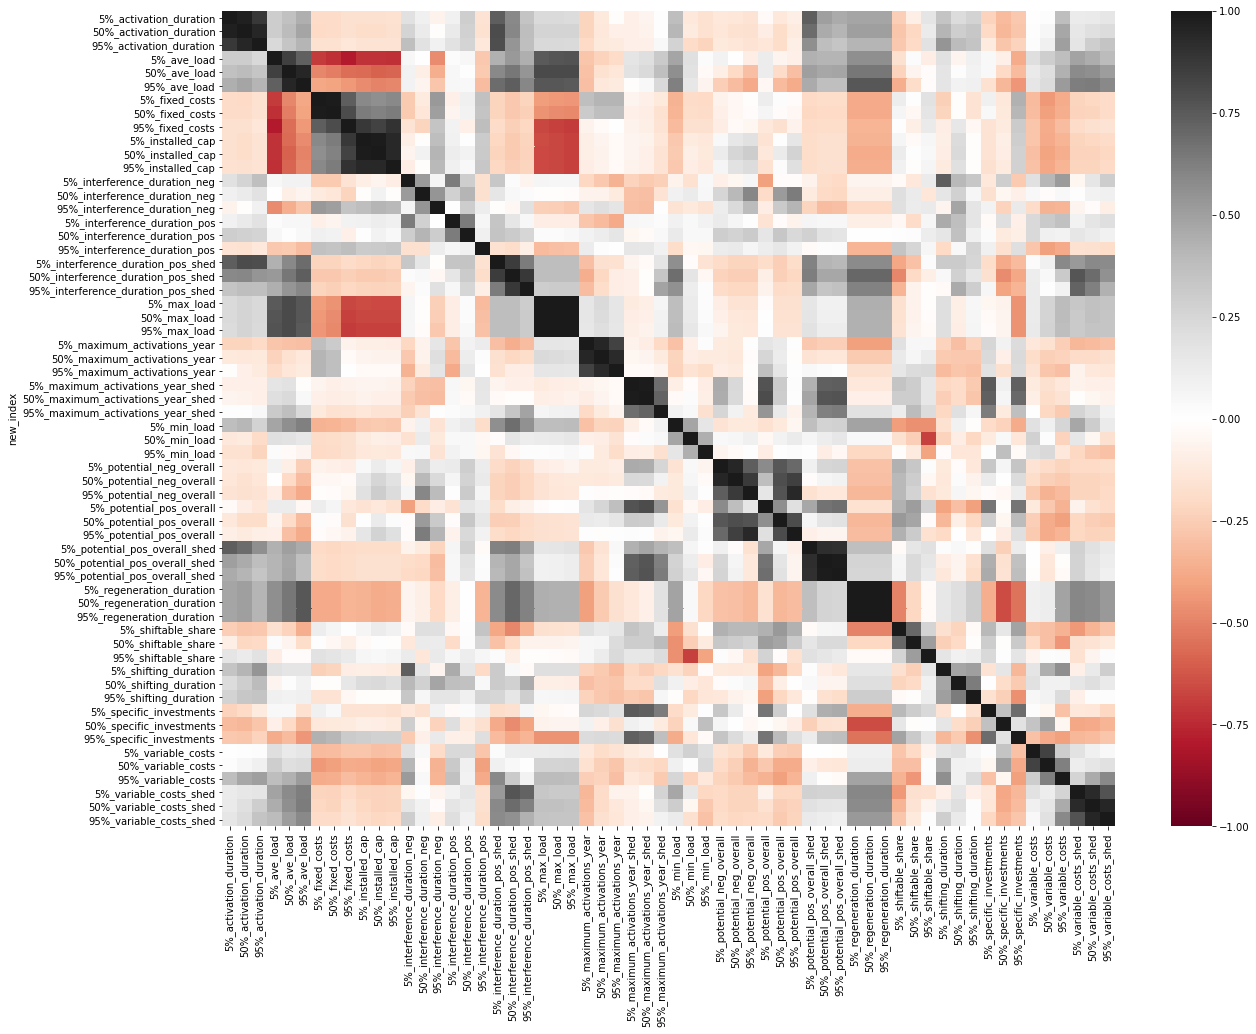

In [22]:
# Show heatmap for all correlations
fig, ax = plt.subplots(figsize=(20, 15))
_ = sns.heatmap(corr_matrix, cmap="RdGy", vmin=-1.0, vmax=1.0)
plt.show()

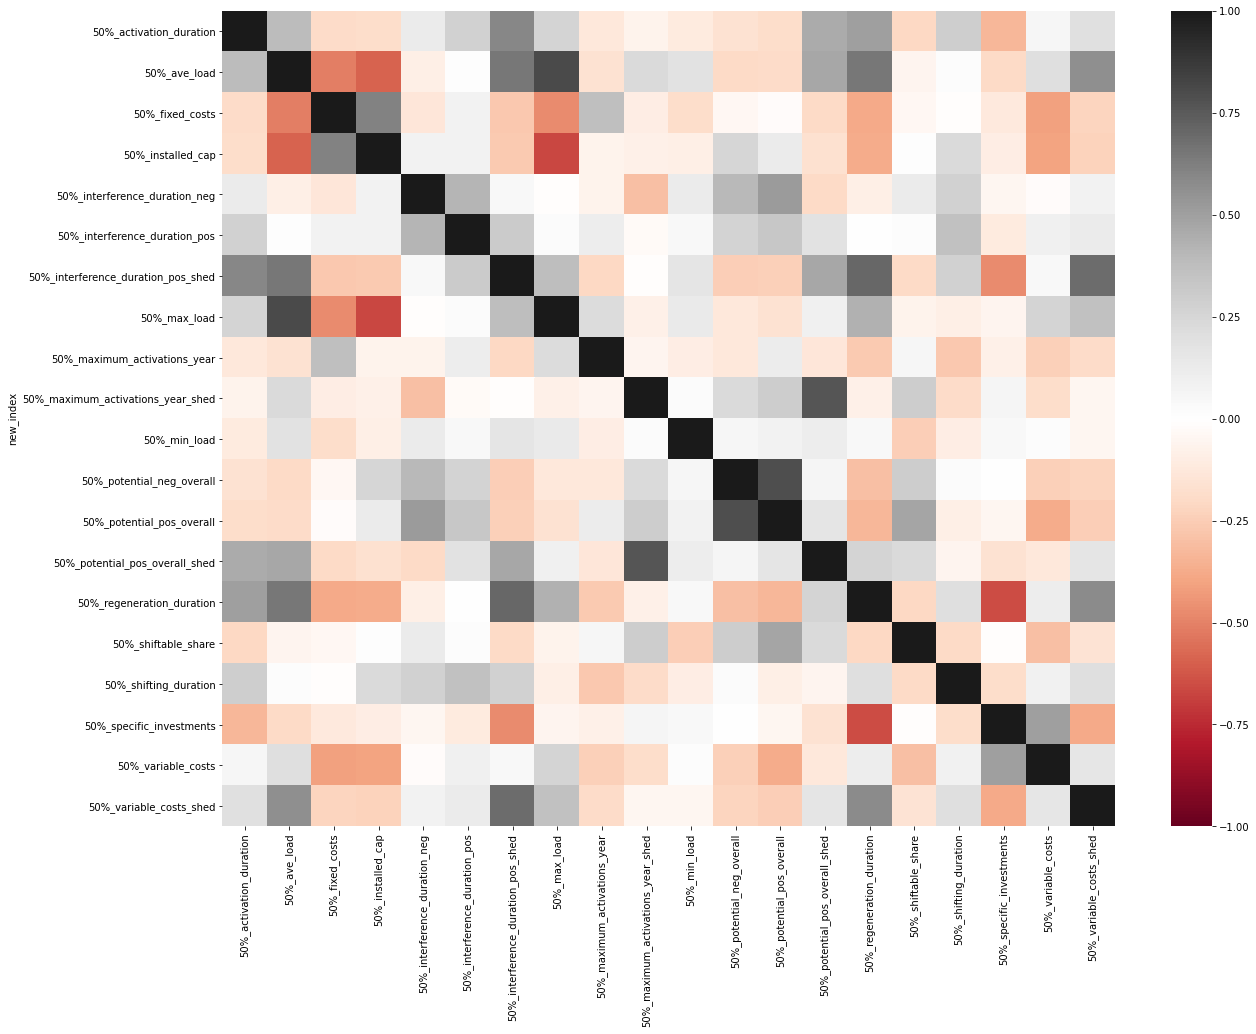

In [23]:
# Show heatmap for median values only
fig, ax = plt.subplots(figsize=(20, 15))
_ = sns.heatmap(corr_matrix_50, cmap="RdGy", vmin=-1.0, vmax=1.0)
plt.show()

## Create consistent trends for future developments
Overview on approach used:
1. Introduce **linear interpolation** for potential and cost parameters:
    * Potential parameters: The values for the status quo, 2030 and 2050 are used. Linear interpolation is made in between.
    * Cost parameters: The minimum cost value is assigned to 2050 since cost increases seem pretty unlikely. Linear interpolation is made between the status quo and 2050 (minimum cost value). Costs of zero are set to 0.01 in order to attribute cost to DR and prevent numeric effects disturbing DR utilization in the model.
2. **Assign remaining** parameters (mostly time-related ones) the same as for the status quo for every year.

Only a **subset of the parameters** needs to be further analyzed since not every parameter is needed for modelling:
* Time-dependent parameters are assumed constant. These comprise:
    * activation duration
    * interference duration (both pos and neg) and shifting duration
    * regeneration duration
* Other parameters are not really resp. not directly used in the modeling approaches for DR. These comprise:
    * average, minimum and maximum load
* This leads to the following remaining parameters focussing on costs and potentials. Since the correlation analysis showed high redundandencies for the potential parameters, only the following remaining parameters will be further analyzed:
    * potential positive overall
    * potential negative overall
    * installed capacity
    * fixed and variable costs
    * specific investments

### Linear interpolation for potential and costs data
* Choose potential and cost parameters to further analyse
* Perform **interpolation on potential and costs parameters** in order to
    1. Fill data gaps and
    2. remove inplausibilities such as potentials changing very strong and not consistent within the five year intervalls used.
* Combine the data to an overall data set once the actions described in the following are done.

In order to come up with consistent trends, it is proceeded as follows:
* For *potential-related* parameters, values for the status quo, 2030 and 2050 are assessed. This serves to
    * depict intermediate trends (such as a temporary increase of a technology) and
    * create a consistent long-term development.
* For *potential-related* parameters, a strong interlinkage exists. In order not to create inconsistencies, development factors are assessed for each of the potential-related columns and the median one is used. This serves to prevent inconsistensies, such as a strongly increasing positive shifting potential while installed capacity only weakly increases or even decreases.
* For *cost-related* parameters, the minimum cost value given is assigned to 2050, thus assuming a cost reduction over time. Zero cost values are replaced by small costs (0.01) in order to prevent modelling artefacts.

In [24]:
# choose parameters to be used (parameters for which some adaptions are needed)
params_to_use = [
    "potential_neg_overall",
    "potential_pos_overall",
    "potential_pos_overall_shed",
    "installed_cap",
    "fixed_costs",
    "variable_costs",
    "variable_costs_shed",
    "specific_investments"
]

params_to_use = [(a, b) for a in quantile_cols for b in params_to_use]

# Slice the parameter values needed
slice_params = all_params_reshaped.loc[:, params_to_use]
slice_params_unjoined = all_params_reshaped_unjoined.loc[:, params_to_use]

In [25]:
# Define potential and cost cols
pot_cols = [
    "potential_neg_overall",
    "potential_pos_overall", 
    "potential_pos_overall_shed",
    "installed_cap"
]
pot_cols = [(a, b) for a in quantile_cols for b in pot_cols]

cost_cols = [
    "specific_investments", 
    "fixed_costs", 
    "variable_costs",
    "variable_costs_shed"
]
cost_cols = [(a, b) for a in quantile_cols for b in cost_cols]

# Determine demand response categories to use for assigning values:
# Use first two index levels corresponding to process category and sector
dr_categories = all_params_reshaped.reset_index(level=2).index.unique()
dr_categories_unjoined = all_params_reshaped_unjoined.reset_index(level=2).index.unique()

In [26]:
# Combined data set
# Instanciate new DataFrame to store manipulated outputs
parameters_for_clustering = pd.DataFrame(
    index=pd.MultiIndex.from_product([[], [], [], []],
    names=["Prozesskategorie", "sector", "year", "kind"]),
    columns=pd.MultiIndex.from_product([[], []])
)

# Create a list of DataFrames to concat
to_concat = [parameters_for_clustering]

for category in dr_categories:
    process = category[0]
    sector = category[1]
    kind = category[2]

    # Use potential values for status quo, 2030 and 2050
    try:
        pot_vals_SQ = slice_params.loc[(process, sector, "SQ", kind), pot_cols].values
    except KeyError:
        continue
    try:
        pot_vals_2030 = slice_params.loc[(process, sector, "2030", kind), pot_cols].values
    except:
        pot_vals_2030 = np.nan
    try:
        pot_vals_2050 = slice_params.loc[(process, sector, "2050", kind), pot_cols].values
    except:
        pot_vals_2050 = pot_vals_SQ
    
    # Determine median development factors to create consistent trends
    factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
    factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)
    
    multi_ix = pd.MultiIndex.from_product(
        [[process], [sector], years, [kind]], 
        names=["Prozesskategorie", "sector", "year", "kind"]
    )
    new_df = pd.DataFrame(
        index=multi_ix, 
        columns=pd.MultiIndex.from_tuples(pot_cols + cost_cols)
    )
    
    new_df.loc[(process, sector, "SQ", kind), pot_cols] = pot_vals_SQ
    new_df.loc[(process, sector, "2030", kind), pot_cols] = pot_vals_2030 * factor_2030
    new_df.loc[(process, sector, "2050", kind), pot_cols] = pot_vals_2050 * factor_2050
    
    # Use cost values
    cost_vals_SQ = slice_params.loc[(process, sector, "SQ", kind), cost_cols]     
    min_costs = slice_params[cost_cols].min()

    # Assign minimum cost value to the year 2050
    new_df.loc[(process, sector, "SQ", kind), cost_cols] = cost_vals_SQ.fillna(0.01)
    new_df.loc[(process, sector, "2050", kind), cost_cols] = min_costs
    new_df[cost_cols] = new_df[cost_cols].replace({0: 0.01})
    
    # Correct dtype, interpolate between status quo, 2030 and 2050 and create common data basis again
    new_df = new_df.astype("float64")
    new_df = new_df.interpolate(axis=0)
    
    to_concat.append(new_df)

parameters_for_clustering = pd.concat([el for el in to_concat], levels=([0, 1, 2]))

<ipython-input-26-70f9a69c70a7>:32: RuntimeWarning: invalid value encountered in true_divide
  factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
<ipython-input-26-70f9a69c70a7>:33: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)
C:\Users\koch_j0\.conda\envs\diss3\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [27]:
# Uncombined data set
# Instanciate new DataFrame to store manipulated outputs
parameters_for_clustering_unjoined = pd.DataFrame(
    index=pd.MultiIndex.from_product([[], [], [], []],
    names=["Prozesskategorie", "sector", "year", "kind"]),
    columns=pd.MultiIndex.from_product([[], []])
)

# Create a list of DataFrames to concat
to_concat = [parameters_for_clustering_unjoined]

for category in dr_categories_unjoined:
    process = category[0]
    sector = category[1]
    kind = category[2]

    # Use potential values for status quo, 2030 and 2050
    try:
        pot_vals_SQ = slice_params_unjoined.loc[(process, sector, "SQ", kind), pot_cols].values
    except KeyError:
        continue
    try:
        pot_vals_2030 = slice_params_unjoined.loc[(process, sector, "2030", kind), pot_cols].values
    except:
        pot_vals_2030 = np.nan
    try:
        pot_vals_2050 = slice_params_unjoined.loc[(process, sector, "2050", kind), pot_cols].values
    except:
        pot_vals_2050 = pot_vals_SQ
    
    # Determine median development factors to create consistent trends
    factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
    factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)
    
    multi_ix = pd.MultiIndex.from_product(
        [[process], [sector], years, [kind]], 
        names=["Prozesskategorie", "sector", "year", "kind"]
    )
    new_df = pd.DataFrame(
        index=multi_ix, 
        columns=pd.MultiIndex.from_tuples(pot_cols + cost_cols)
    )
    
    new_df.loc[(process, sector, "SQ", kind), pot_cols] = pot_vals_SQ
    new_df.loc[(process, sector, "2030", kind), pot_cols] = pot_vals_2030 * factor_2030
    new_df.loc[(process, sector, "2050", kind), pot_cols] = pot_vals_2050 * factor_2050
    
    # Use cost values
    cost_vals_SQ = slice_params_unjoined.loc[(process, sector, "SQ", kind), cost_cols]     
    min_costs = slice_params_unjoined[cost_cols].min()

    # Assign minimum cost value to the year 2050
    new_df.loc[(process, sector, "SQ", kind), cost_cols] = cost_vals_SQ.fillna(0.01)
    new_df.loc[(process, sector, "2050", kind), cost_cols] = min_costs
    new_df[cost_cols] = new_df[cost_cols].replace({0: 0.01})
    
    # Correct dtype, interpolate between status quo, 2030 and 2050 and create common data basis again
    new_df = new_df.astype("float64")
    new_df = new_df.interpolate(axis=0)
    
    to_concat.append(new_df)

parameters_for_clustering_unjoined = pd.concat([el for el in to_concat], levels=([0, 1, 2]))

<ipython-input-27-2134fde07291>:32: RuntimeWarning: invalid value encountered in true_divide
  factor_2030 = np.nanmedian(pot_vals_2030 / pot_vals_SQ)
<ipython-input-27-2134fde07291>:33: RuntimeWarning: invalid value encountered in true_divide
  factor_2050 = np.nanmedian(pot_vals_2050 / pot_vals_SQ)


### Assignment of remaining (time-related parameters)
Assume time-related parameters to remain constant over time, i.e. the same as in the status quo data.

In [28]:
# Assign remaining (mostly time-related) parameters
params_remaining = [
    "interference_duration_neg",
    "interference_duration_pos",
    "interference_duration_pos_shed",
    "maximum_activations_year",
    "maximum_activations_year_shed",
    "regeneration_duration", 
    "shifting_duration"
]

params_remaining = [
    (a, b) for a in quantile_cols for b in params_remaining
]

# Slice the parameter values needed (both data sets - combined and uncombined)
slice_params = all_params_reshaped.loc[:, params_remaining]
slice_params_unjoined = all_params_reshaped_unjoined.loc[:, params_remaining]

parameters_for_clustering = parameters_for_clustering.reindex(
    columns=pot_cols+cost_cols+params_remaining
)
parameters_for_clustering_unjoined = parameters_for_clustering_unjoined.reindex(
    columns=pot_cols+cost_cols+params_remaining
)

# Use status quo values (best data basis) for all years
parameters_for_clustering.loc[
    parameters_for_clustering.index.get_level_values(2) == "SQ", params_remaining
] = (
    slice_params.loc[slice_params.index.get_level_values(2) == "SQ", params_remaining]
)
parameters_for_clustering.fillna(method="ffill", inplace=True)

parameters_for_clustering_unjoined.loc[
    parameters_for_clustering_unjoined.index.get_level_values(2) == "SQ", params_remaining
] = (
    slice_params_unjoined.loc[slice_params_unjoined.index.get_level_values(2)
                              == "SQ", params_remaining]
)
parameters_for_clustering_unjoined.fillna(method="ffill", inplace=True)

### Slightly rearrange and filter status quo data

In [29]:
# Flatten columns (both data sets - combined and uncombined)
parameters_for_clustering.loc[("new_cols","","",""), :] = (
    parameters_for_clustering.columns.get_level_values(0) 
    + "_" + parameters_for_clustering.columns.get_level_values(1)
)

parameters_for_clustering.columns = parameters_for_clustering.loc[("new_cols","","","")]
parameters_for_clustering.columns.name = "parameters"
parameters_for_clustering.drop(index=("new_cols","","",""), inplace=True)

parameters_for_clustering_unjoined.loc[("new_cols","","",""), :] = (
    parameters_for_clustering_unjoined.columns.get_level_values(0) 
    + "_" + parameters_for_clustering_unjoined.columns.get_level_values(1)
)

parameters_for_clustering_unjoined.columns = parameters_for_clustering_unjoined.loc[("new_cols","","","")]
parameters_for_clustering_unjoined.columns.name = "parameters"
parameters_for_clustering_unjoined.drop(index=("new_cols","","",""), inplace=True)

# Filter status quo data
parameters_for_clustering_status_quo = parameters_for_clustering.loc[
    parameters_for_clustering.index.get_level_values(2) == "SQ"
]

# Cluster data
* Do a clustering using K-Means and the cluster parameters defined in the above parameter settings (alternative: agglomerative clustering using ward linkage).
* Default: Cluster within sectors by shifting times, positive interference duration, variable costs as well as specific investments

## Do the actual clustering
* Determine the number of clusters per sector and shifting resp. shedding eligibility
* Perform a K-Means clustering on the data (alternative: agglomerative clustering using ward linkage)

In [30]:
# Initialize the column to store the cluster label
parameters_for_clustering_status_quo["cluster"] = 0

cluster_string = f"Number of clusters for {cluster_algo} clustering:"
print(cluster_string)
print("-" * len(cluster_string)) 

# Increase cluster numbers by (arbitratily chosen) increments
# in order not to overwrite cluster information
increment = 100

for sector, kind in parameters_for_clustering_status_quo.reset_index(level=[0, 2]).index.unique():
    # Determine the number of clusters per sector and print it
    n = math.ceil(
        parameters_for_clustering_status_quo[
            (parameters_for_clustering_status_quo.index.get_level_values(1) == sector)
            & (parameters_for_clustering_status_quo.index.get_level_values(3) == kind)
        ].shape[0] * share_clusters
    )
    print(f"{sector: <9} / {kind : <20}: {n : >3}")
    
    if cluster_algo == "KMeans":
        # Do the actual clustering and assign the cluster labels
        parameters_for_clustering_status_quo.loc[
            (parameters_for_clustering_status_quo.index.get_level_values(1) == sector)
            & (parameters_for_clustering_status_quo.index.get_level_values(3) == kind), 
            "cluster"] = (
                KMeans(n_clusters=n).fit(
                    parameters_for_clustering_status_quo.loc[
                        (parameters_for_clustering_status_quo.index.get_level_values(1) == sector)
                        & (parameters_for_clustering_status_quo.index.get_level_values(3) == kind), 
                        cluster_parameters
                    ].values
                ).labels_ + 1
            )
        
    elif cluster_algo == "ward":
        # Do the actual clustering and assign the cluster labels
        parameters_for_clustering_status_quo.loc[
            parameters_for_clustering_status_quo.index.get_level_values(1) == sector, "cluster"] = (
                AgglomerativeClustering(n_clusters=n, linkage="ward").fit(
                    parameters_for_clustering_status_quo.loc[
                        parameters_for_clustering_status_quo.index.get_level_values(1) 
                        == sector, cluster_parameters
                    ].values
                ).labels_ + 1       
            )

    # Increment the cluster labels to avoid overwriting in the next iteration 
    # (cluster numbers start with zero)
    parameters_for_clustering_status_quo.loc[
        parameters_for_clustering_status_quo["cluster"] != 0, "cluster"
    ] += increment

# Print the number of unique cluster labels (cross check)
print(f"Original number of clusters     : {parameters_for_clustering_status_quo['cluster'].nunique() : >3}")

Number of clusters for KMeans clustering:
-----------------------------------------
ind       / shift_only          :   1
ind       / shift_shed          :   1
ind       / shed_only           :   1
tcs       / shed_only           :   1
tcs       / shift_only          :   1
hoho      / shift_only          :   1
hoho      / shift_shed          :   1
tcs+hoho  / shift_only          :   1
Original number of clusters     :   8


**Cluster assignment**:
Assign cluster information for future years

In [31]:
# Drop year from index
parameters_for_clustering.reset_index(level=2, inplace=True)
parameters_for_clustering_unjoined.reset_index(level=2, inplace=True)
parameters_for_clustering_status_quo.reset_index(level=2, inplace=True)

for year in years:
    parameters_for_clustering.loc[
        parameters_for_clustering["year"] == year, "cluster"
    ] = parameters_for_clustering_status_quo["cluster"].values
    
    # Assgin values for uncombined data set
    parameters_for_clustering_unjoined.loc[
        parameters_for_clustering_unjoined["year"] == year, "cluster"
    ] = parameters_for_clustering_status_quo["cluster"]
    
    # Handle missing cluster information
    no_cluster_ixs = list(set(parameters_for_clustering_unjoined[
        (parameters_for_clustering_unjoined["year"] == year)
        & (parameters_for_clustering_unjoined["cluster"].isna())
    ].index.get_level_values(0)))
    no_cluster_ixs_tcs_hoho = [(i, j, k) for i in no_cluster_ixs for j in ["tcs+hoho"] for k in ["shift_only"]]

    # Use only the first index level to be able to assign values (second index levels won't match)
    clusters_to_use = parameters_for_clustering[
        parameters_for_clustering["year"] == year 
    ].loc[no_cluster_ixs_tcs_hoho, "cluster"].to_frame()
    clusters_to_use = clusters_to_use.set_index(clusters_to_use.index.get_level_values(0))

    # Use an excerpt of the overall DataFrame to assign the cluster info
    excerpt = parameters_for_clustering_unjoined.loc[
        (parameters_for_clustering_unjoined["year"] == year)
        & (parameters_for_clustering_unjoined["cluster"].isna()),
        "cluster"
    ].to_frame()
    excerpt = excerpt.reset_index().set_index("Prozesskategorie")

    excerpt["cluster"] = clusters_to_use["cluster"]
    excerpt = excerpt.set_index("sector", append=True)

    parameters_for_clustering_unjoined.loc[
        (parameters_for_clustering_unjoined["year"] == year)
        & (parameters_for_clustering_unjoined["cluster"].isna()),
        "help_sector"
    ] = "tcs+hoho"
    parameters_for_clustering_unjoined.loc[
        (parameters_for_clustering_unjoined["year"] == year)
        & (parameters_for_clustering_unjoined["cluster"].isna()),
        "cluster"
    ] = excerpt.loc[:, "cluster"]

## Show and explore the clusters
Print the clusters in order to visually inspect them

In [32]:
if print_clusters:
    for el in np.sort(parameters_for_clustering_status_quo["cluster"].unique()):
        print(20 * "-")
        print("cluster number: "+str(el))
        print(20 * "-")
        display(parameters_for_clustering_status_quo[parameters_for_clustering_status_quo["cluster"] == el])

--------------------
cluster number: 101
--------------------


,,parameters,year,5%_potential_neg_overall,5%_potential_pos_overall,5%_potential_pos_overall_shed,5%_installed_cap,50%_potential_neg_overall,50%_potential_pos_overall,50%_potential_pos_overall_shed,50%_installed_cap,95%_potential_neg_overall,...,50%_regeneration_duration,50%_shifting_duration,95%_interference_duration_neg,95%_interference_duration_pos,95%_interference_duration_pos_shed,95%_maximum_activations_year,95%_maximum_activations_year_shed,95%_regeneration_duration,95%_shifting_duration,cluster
Prozesskategorie,sector,kind,,,,,,,,,,,,,,,,,,,,,
Klimakälte,tcs+hoho,shift_only,SQ,7.24,98.02,0,8510.8,869.38,1515.59,0,9373,7540.45,...,0,0.38,11.7,0.95,0,858.75,0,0,1.66,101
Nachtspeicherheizungen,tcs+hoho,shift_only,SQ,2297.5,418.25,0,17162.5,6542.5,3591,0,25975,31774,...,0,7.55,11.7,12,0,773.35,0,0,19.5,101
Warmwasserbereitstellung,tcs+hoho,shift_only,SQ,492.5,265.55,0,12521.1,1494,3580,0,21445.5,13220.9,...,0,9,12,12,0,817.8,0,0,19.5,101
Wärmepumpen,tcs+hoho,shift_only,SQ,0,16,0,1525.75,403.04,660,0,2269.5,1561.78,...,0,3,2.8,65,0,703,0,0,42.25,101


--------------------
cluster number: 201
--------------------


,,parameters,year,5%_potential_neg_overall,5%_potential_pos_overall,5%_potential_pos_overall_shed,5%_installed_cap,50%_potential_neg_overall,50%_potential_pos_overall,50%_potential_pos_overall_shed,50%_installed_cap,95%_potential_neg_overall,...,50%_regeneration_duration,50%_shifting_duration,95%_interference_duration_neg,95%_interference_duration_pos,95%_interference_duration_pos_shed,95%_maximum_activations_year,95%_maximum_activations_year_shed,95%_regeneration_duration,95%_shifting_duration,cluster
Prozesskategorie,sector,kind,,,,,,,,,,,,,,,,,,,,,
Heizungsumwälzpumpen,hoho,shift_shed,SQ,1468,1468,615.6,2072.5,2283,2283,1894.69,2500,2316,...,0,0.35,0,20.4,0,924.4,396.45,0,1.37,201


--------------------
cluster number: 301
--------------------


,,parameters,year,5%_potential_neg_overall,5%_potential_pos_overall,5%_potential_pos_overall_shed,5%_installed_cap,50%_potential_neg_overall,50%_potential_pos_overall,50%_potential_pos_overall_shed,50%_installed_cap,95%_potential_neg_overall,...,50%_regeneration_duration,50%_shifting_duration,95%_interference_duration_neg,95%_interference_duration_pos,95%_interference_duration_pos_shed,95%_maximum_activations_year,95%_maximum_activations_year_shed,95%_regeneration_duration,95%_shifting_duration,cluster
Prozesskategorie,sector,kind,,,,,,,,,,,,,,,,,,,,,
Gefrierschränke und -truhen,hoho,shift_only,SQ,0,408,0,2185.3,0,780.49,0,2431,1530.3,...,0,0.5,5.12,5.8,0,8760,0,0,5.4,301
Geschirrspüler,hoho,shift_only,SQ,0,0,0,52086.2,484.82,0,0,52232,1986.87,...,0,18,9.75,20.4,0,898.25,0,0,24,301
Kühl- und Gefrierkombinationen,hoho,shift_only,SQ,500,500,0,996,980,980,0,996,996,...,0,2,9.75,20.4,0,924.4,0,0,11.1,301
Kühlschränke,hoho,shift_only,SQ,0,548.6,0,3687.2,0,1317.16,0,4103,2824.3,...,0,0.5,13.9,11.2,0,8760,0,0,5.4,301
Waschmaschinen,hoho,shift_only,SQ,0,0,0,66032.6,380.36,16.54,0,66217.5,2121.15,...,0,3.5,9.3,20.4,0,924.4,0,0,18,301
Wäschetrockner,hoho,shift_only,SQ,0,0,0,35126.8,359.32,0,0,35700.5,1476.8,...,0,3.5,9.75,20.4,0,876,0,0,16.8,301


--------------------
cluster number: 401
--------------------


,,parameters,year,5%_potential_neg_overall,5%_potential_pos_overall,5%_potential_pos_overall_shed,5%_installed_cap,50%_potential_neg_overall,50%_potential_pos_overall,50%_potential_pos_overall_shed,50%_installed_cap,95%_potential_neg_overall,...,50%_regeneration_duration,50%_shifting_duration,95%_interference_duration_neg,95%_interference_duration_pos,95%_interference_duration_pos_shed,95%_maximum_activations_year,95%_maximum_activations_year_shed,95%_regeneration_duration,95%_shifting_duration,cluster
Prozesskategorie,sector,kind,,,,,,,,,,,,,,,,,,,,,
Belüftung,tcs,shift_only,SQ,1.26,16.98,0,786.3,54.17,80.22,0,1077,9070,...,0,3,4.26,2.62,0,865.05,0,0,20.1,401
Kühlhäuser,tcs,shift_only,SQ,113.4,98.85,0,172.1,197.5,230,0,200,225.5,...,0,2,4.26,4.66,0,438,0,0,5.4,401
Prozesskälte,tcs,shift_only,SQ,32.42,123.48,0,1588.7,81.43,206.73,0,2234,655.6,...,0,0.5,3.8,4.66,0,438,0,0,1.7,401
Prozesskälte Handel,tcs,shift_only,SQ,110.9,110.9,0,655.4,389,389,0,655.4,655.4,...,0,3,4.26,0,0,438,0,0,20.1,401
Prozesswärme,tcs,shift_only,SQ,829,194.5,0,1022.5,1963,982,0,1022.5,2045.8,...,0,3,4.26,4.66,0,438,0,0,20.1,401
Pumpenanwendungen in der Wasserversorgung,tcs,shift_only,SQ,135.28,173.92,0,251.6,290,290,0,773,502.78,...,0,9,5.42,5.42,0,887.1,0,0,20.1,401
Zerkleinerer,tcs,shift_only,SQ,2.7,8.91,0,28.1,13.68,21.6,0,38,32.83,...,0,8.5,4.72,4.72,0,402,0,0,21.87,401


--------------------
cluster number: 501
--------------------


,,parameters,year,5%_potential_neg_overall,5%_potential_pos_overall,5%_potential_pos_overall_shed,5%_installed_cap,50%_potential_neg_overall,50%_potential_pos_overall,50%_potential_pos_overall_shed,50%_installed_cap,95%_potential_neg_overall,...,50%_regeneration_duration,50%_shifting_duration,95%_interference_duration_neg,95%_interference_duration_pos,95%_interference_duration_pos_shed,95%_maximum_activations_year,95%_maximum_activations_year_shed,95%_regeneration_duration,95%_shifting_duration,cluster
Prozesskategorie,sector,kind,,,,,,,,,,,,,,,,,,,,,
Beleuchtung,tcs,shed_only,SQ,0,0,0,12.74,4.44,2.41,0,19.4,12.06,...,0,3,2.36,2.36,0,267,0,0,20.91,501


--------------------
cluster number: 601
--------------------


,,parameters,year,5%_potential_neg_overall,5%_potential_pos_overall,5%_potential_pos_overall_shed,5%_installed_cap,50%_potential_neg_overall,50%_potential_pos_overall,50%_potential_pos_overall_shed,50%_installed_cap,95%_potential_neg_overall,...,50%_regeneration_duration,50%_shifting_duration,95%_interference_duration_neg,95%_interference_duration_pos,95%_interference_duration_pos_shed,95%_maximum_activations_year,95%_maximum_activations_year_shed,95%_regeneration_duration,95%_shifting_duration,cluster
Prozesskategorie,sector,kind,,,,,,,,,,,,,,,,,,,,,
Elektrostahlherstellung (Lichtbogenofen),ind,shed_only,SQ,31.75,568,498,842.67,327,957,911.5,1730,734.75,...,2,1,1.08,5.84,5.4,4090,46.5,0.2,4.7,601


--------------------
cluster number: 701
--------------------


,,parameters,year,5%_potential_neg_overall,5%_potential_pos_overall,5%_potential_pos_overall_shed,5%_installed_cap,50%_potential_neg_overall,50%_potential_pos_overall,50%_potential_pos_overall_shed,50%_installed_cap,95%_potential_neg_overall,...,50%_regeneration_duration,50%_shifting_duration,95%_interference_duration_neg,95%_interference_duration_pos,95%_interference_duration_pos_shed,95%_maximum_activations_year,95%_maximum_activations_year_shed,95%_regeneration_duration,95%_shifting_duration,cluster
Prozesskategorie,sector,kind,,,,,,,,,,,,,,,,,,,,,
Calciumcarbid-Herstellung (Lichtbogenofen),ind,shift_shed,SQ,4.35,4.35,41.4,58.2,13,13,63,78,19.95,...,2,6,4.68,2.91,2.36,279.5,0,0.2,31.2,701
Chlor-Alkali-Elektrolyse,ind,shift_shed,SQ,35.6,267.15,482.75,895.7,299,622,575,1408,679.2,...,2,2,4.13,7.99,7.99,140.5,47,0.2,10.4,701
Gießereien (Induktionsofen),ind,shift_shed,SQ,5.2,5.2,37.6,55.3,25,25,115,148,44.8,...,2,6,4.72,2.36,2.36,80,0,0.2,6.38,701
Kupfer- und Zinkherstellung (Elektrolyse),ind,shift_shed,SQ,7.8,7.8,20.1,177.5,15,15,149,182,22.2,...,2,4,4.68,6.78,6.56,80,40,0.2,7,701
Kühlung (Lebensmittelindustrie),ind,shift_shed,SQ,274.5,270.75,0,552,450,362.5,0,552,558,...,2,6,4.68,3.82,0,455.95,0,0.2,22.2,701
Primäraluminiumelektrolyse,ind,shift_shed,SQ,30,195.4,203.85,759.2,40,295,663,938,211.7,...,2,3.85,4.32,2.27,4,757.5,121.2,0.2,6.1,701
Zementherstellung,ind,shift_shed,SQ,54,90,167.25,315.8,174,313,246.5,397,364,...,2,21.4,17.08,13.18,14.46,473.9,286.25,0.2,48.6,701


--------------------
cluster number: 801
--------------------


,,parameters,year,5%_potential_neg_overall,5%_potential_pos_overall,5%_potential_pos_overall_shed,5%_installed_cap,50%_potential_neg_overall,50%_potential_pos_overall,50%_potential_pos_overall_shed,50%_installed_cap,95%_potential_neg_overall,...,50%_regeneration_duration,50%_shifting_duration,95%_interference_duration_neg,95%_interference_duration_pos,95%_interference_duration_pos_shed,95%_maximum_activations_year,95%_maximum_activations_year_shed,95%_regeneration_duration,95%_shifting_duration,cluster
Prozesskategorie,sector,kind,,,,,,,,,,,,,,,,,,,,,
Altpapierrecycling (Pulper),ind,shift_only,SQ,33.5,357.5,410.7,413.8,123,424.5,588,592.5,425,...,2,4.3,4.7,2.91,2.29,2885.5,0,0.2,31.2,801
Belüftung,ind,shift_only,SQ,0,0.97,0,255.2,14.3,11.97,0,374,321.75,...,2,5.15,1.7,2,2,865.05,0,0.2,25.5,801
Druckluftanwendungen,ind,shift_only,SQ,56.15,33.56,0,1939.7,1045.5,910.85,0,1939.7,2578,...,2,5.15,4.68,1.8,0,455.95,0,0.2,25.5,801
Holz- und Zellstoffherstellung,ind,shift_only,SQ,44.95,195.4,155.4,221.85,84,252.86,300,324,366.55,...,2,7.8,6.45,5.12,5.18,1225,286.25,0.2,28.8,801
Klimakälte,ind,shift_only,SQ,0,0,0,790.7,50.35,0,0,1049,69.47,...,2,5.15,4.68,3.82,0,438,0,0.2,25.5,801
Luftzerlegung,ind,shift_only,SQ,12.6,12.6,117.2,164.3,45,45,146,194,148.2,...,2,4.3,3.26,3.82,3.07,365,48.5,0.2,30,801
Papiermaschinen,ind,shift_only,SQ,53,86,851.3,197.6,111,204,1214,1412,189.25,...,2,11.2,7.02,5.6,5.65,710,0,0.2,31.2,801
Prozesskälte,ind,shift_only,SQ,142.16,207.46,0,475.3,259.04,322.34,0,613,948.3,...,2,5.15,7.25,5.1,0,438,0,0.2,25.5,801


Drop unsensible tcs cluster:
* Lighting in the tcs sector (flower industry / greenhouses) is supposed to be eligible for load shedding, but does not have any shedding potential information.
* Thus, the process and its corresponding cluster will be removed from the data set.

In [33]:
# Drop kind (shifting / shedding) from index
parameters_for_clustering = parameters_for_clustering.reset_index(level=2, drop=False)
parameters_for_clustering_unjoined = parameters_for_clustering_unjoined.reset_index(level=2, drop=False)

In [34]:
# Drop unsensible tcs cluster
to_drop = [("Beleuchtung", "tcs")]
parameters_for_clustering_status_quo.drop(index=to_drop, inplace=True)
parameters_for_clustering.drop(index=to_drop, inplace=True)
parameters_for_clustering_unjoined.drop(index=to_drop, inplace=True)

C:\Users\koch_j0\.conda\envs\diss3\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


## Read in and match availability data
* Read in the availability time series data collected from Benz (2019), Odeh (2019) and Stange (2019).
* Match the data to the respective demand response categories.

In [35]:
# Read in availability time series data
availability_ind_pos = pd.read_excel(path_folder_availability+filename_availability_in,
                                     sheet_name = "ind_pos", header=0, index_col=0)

availability_ind_neg = pd.read_excel(path_folder_availability+filename_availability_in,
                                     sheet_name = "ind_neg", header=0, index_col=0)

availability_tcs_pos = pd.read_excel(path_folder_availability+filename_availability_in,
                                     sheet_name = "tcs_pos", header=0, index_col=0)

availability_tcs_neg = pd.read_excel(path_folder_availability+filename_availability_in,
                                     sheet_name = "tcs_neg", header=0, index_col=0)

availability_hoho_pos = pd.read_excel(path_folder_availability+filename_availability_in,
                                     sheet_name = "hoho_pos", header=0, index_col=0)

availability_hoho_neg = pd.read_excel(path_folder_availability+filename_availability_in,
                                     sheet_name = "hoho_neg", header=0, index_col=0)

In [36]:
# Map the demand response categories to the column names used for the availability time series
# (naming conventions from the bachelor theses are widely used)
availability_cats_ind_pos = {
    'normiertes\nLRP Alu': ('Primäraluminiumelektrolyse', 'ind'),
    'normiertes\nLRP CHL': ('Chlor-Alkali-Elektrolyse', 'ind'),
    'normiertes\nLRP HS': ('Holz- und Zellstoffherstellung', 'ind'),
    'normiertes\nLRP PM': ('Papiermaschinen', 'ind'),
    'normiertes\nLRP ES': ('Elektrostahlherstellung (Lichtbogenofen)', 'ind'),
    'normiertes\nLRP RZM': ('Zementherstellung', 'ind'),
    'normiertes\nLRP KUZI': ('Kupfer- und Zinkherstellung (Elektrolyse)', 'ind'),
    'normiertes\nLRP AP': ('Altpapierrecycling (Pulper)', 'ind')
}

availability_cats_ind_neg = {
    'normiertes\nLZP Alu': ('Primäraluminiumelektrolyse', 'ind'),
    'normiertes\nLZP CHL': ('Chlor-Alkali-Elektrolyse', 'ind'),
    'normiertes\nLZP HS': ('Holz- und Zellstoffherstellung', 'ind'),
    'normiertes\nLZP PM': ('Papiermaschinen', 'ind'),
    'normiertes\nLZP ES': ('Elektrostahlherstellung (Lichtbogenofen)', 'ind'),
    'normiertes\nLZP RZM': ('Zementherstellung', 'ind'),
    'normiertes\nLZP KUZI': ('Kupfer- und Zinkherstellung (Elektrolyse)', 'ind'),
    'normiertes\nLZP AP': ('Altpapierrecycling (Pulper)', 'ind')
}

# Note: Instead of KGR in the tcs sector, profiles for food retailing are introduced and used.
availability_cats_tcs_pos = {
    'Lastabschaltung LÜ normiert': ('Belüftung', 'tcs'), 
    'Lastabschaltung WVP normiert': ('Pumpenanwendungen in der Wasserversorgung', 'tcs'),
    'Lastabschaltung KGR normiert': ('Prozesskälte Handel', 'tcs'),
    'Lastabschaltung KÜ normiert': ('Kühlhäuser', 'tcs'),
    'Lastabschaltung KA normiert': ('Klimakälte', 'tcs'),  
    'Lastabschaltung EH normiert': ('Nachtspeicherheizungen', 'tcs'),
    'Lastabschaltung WP normiert': ('Wärmepumpen', 'tcs'), 
    'Lastabschaltung WW normiert': ('Warmwasserbereitstellung', 'tcs')
}

availability_cats_tcs_neg = {
    'Lastzuschaltung LÜ normiert': ('Belüftung', 'tcs'),
    'Lastzuschaltung WVP normiert': ('Pumpenanwendungen in der Wasserversorgung', 'tcs'),
    'Lastzuschaltung KGR normiert': ('Prozesskälte Handel', 'tcs'),
    'Lastzuschaltung KÜ normiert': ('Kühlhäuser', 'tcs'),
    'Lastzuschaltung KA normiert': ('Klimakälte', 'tcs'), 
    'Lastzuschaltung EH normiert': ('Nachtspeicherheizungen', 'tcs'),
    'Lastzuschaltung WP normiert': ('Wärmepumpen', 'tcs'), 
    'Lastzuschaltung WW normiert': ('Warmwasserbereitstellung', 'tcs')
}

availability_cats_hoho_pos = {
    'Lastabschaltung KGR': ('Kühlschränke', 'hoho'), 
    'Lastabschaltung WM': ('Waschmaschinen', 'hoho'), 
    'Lastabschaltung WT': ('Wäschetrockner', 'hoho'),
    'Lastabschaltung GS': ('Geschirrspüler', 'hoho'), 
    'Lastabschaltung NH normiert': ('Nachtspeicherheizungen', 'hoho'),
    'Lastabschaltung WP normiert': ('Wärmepumpen', 'hoho'), 
    'Lastabschaltung UP': ('Heizungsumwälzpumpen', 'hoho'),
    'Lastabschaltung RK': ('Klimakälte', 'hoho'), 
    'Lastabschaltung WW Tag': ('Warmwasserbereitstellung', 'hoho')
}

availability_cats_hoho_neg = {
    'Lastzuschaltung KGR normiert': ('Kühlschränke', 'hoho'),
    'Lastzuschaltung WM normiert': ('Waschmaschinen', 'hoho'),
    'Lastzuschaltung WT normiert': ('Wäschetrockner', 'hoho'),
    'Lastzuschaltung GS normiert': ('Geschirrspüler', 'hoho'), 
    'Lastzuschaltung NH normiert': ('Nachtspeicherheizungen', 'hoho'),
    'Lastzuschaltung WP normiert': ('Wärmepumpen', 'hoho'),
    'Lastzuschaltung RK': ('Klimakälte', 'hoho'), 
    'Lastzuschaltung WW normiert Tag': ('Warmwasserbereitstellung', 'hoho')
}

# Change column names
availability_ind_pos = map_column_names(availability_ind_pos, availability_cats_ind_pos)
availability_ind_neg = map_column_names(availability_ind_neg, availability_cats_ind_neg)
availability_tcs_pos = map_column_names(availability_tcs_pos, availability_cats_tcs_pos)
availability_tcs_neg = map_column_names(availability_tcs_neg, availability_cats_tcs_neg)
availability_hoho_pos = map_column_names(availability_hoho_pos, availability_cats_hoho_pos)
availability_hoho_neg = map_column_names(availability_hoho_neg, availability_cats_hoho_neg)

In [37]:
# Introduce shortcut for availability time series
availabilities_dict = {
    ("ind", "pos"): availability_ind_pos,
    ("ind", "neg"): availability_ind_neg,
    ("tcs", "pos"): availability_tcs_pos,
    ("tcs", "neg"): availability_tcs_neg,
    ("hoho", "pos"): availability_hoho_pos,
    ("hoho", "neg"): availability_hoho_neg
}

## Create availability time series for demand response categories for which availability info is missing

In general, there are three options for filling up the missing availability information. All of these are used in the order they are mentioned:
1. Assign the existing availability time series of another process / demand response category due to large similarities (assumed).
2. Create a synthetic load profile by defining availability factors for hours, weekdays and months and combining them (as done in Gils 2015).
3. Assign a constant availability profile for the entire year when load is assumed to be rather time-invariant.

The folowing availability information is used:
* Industry sector:
    * Foundries (German: "Gießereien") will be assigned the value for copper and zinc.
    * Calcium carbide will be assigned the value for electric furnace steel.
    * For the remaining categories, no profiles are available. As a first proxy, a constant availability profile is assumed.
* Tcs sector:
    * Process cold is assigned the value for storage cooling.
    * In the first place, for all categories not covered, a constant availability profile is assumed. _&rarr; Needs to be changed!_
* Household sector:
    * fride-freezer combinations as well as freezers will be assigned the same profile as fridges.
    * For all remaining categories not covered, a constant availability profile is assumed. _&rarr; Needs to be changed!_

### Use availability time series of existing categories

In [38]:
# Boadcast values from existing demand response categories

# Industry sector
ind_mapping = {
    ('Calciumcarbid-Herstellung (Lichtbogenofen)', 'ind'): 
    ('Elektrostahlherstellung (Lichtbogenofen)', 'ind'),
    ('Gießereien (Induktionsofen)', 'ind'): 
    ('Kupfer- und Zinkherstellung (Elektrolyse)', 'ind')
}

for k, v in ind_mapping.items():
    availability_ind_pos[k] = availability_ind_pos[v]
    availability_ind_neg[k] = availability_ind_neg[v]

# tcs
tcs_mapping = {
    ('Prozesskälte', 'tcs'): ('Kühlhäuser', 'tcs')
}

for k, v in tcs_mapping.items():
    availability_tcs_pos[k] = availability_tcs_pos[v]
    availability_tcs_neg[k] = availability_tcs_neg[v]

# households
hoho_mapping = {
    ('Kühl- und Gefrierkombinationen', 'hoho'): ('Kühlschränke', 'hoho'),
    ('Gefrierschränke und -truhen', 'hoho'): ('Kühlschränke', 'hoho')
}

for k, v in hoho_mapping.items():
    availability_hoho_pos[k] = availability_hoho_pos[v]
    availability_hoho_neg[k] = availability_hoho_neg[v]

In [39]:
# Determine for which categories availability time series are still missing
for key, value in availabilities_dict.items():
    determine_missing_cols(
        dr_categories_unjoined.droplevel(2), 
        value, 
        sector=key[0], 
        direction=key[1]
    )

Missing columns for ind in positive direction:
----------------------------------------------
[('Klimakälte', 'ind'), ('Druckluftanwendungen', 'ind'), ('Prozesskälte', 'ind'), ('Luftzerlegung', 'ind'), ('Belüftung', 'ind'), ('Kühlung (Lebensmittelindustrie)', 'ind')]

Missing columns for ind in negative direction:
----------------------------------------------
[('Klimakälte', 'ind'), ('Druckluftanwendungen', 'ind'), ('Prozesskälte', 'ind'), ('Luftzerlegung', 'ind'), ('Belüftung', 'ind'), ('Kühlung (Lebensmittelindustrie)', 'ind')]

Missing columns for tcs in positive direction:
----------------------------------------------
[('Beleuchtung', 'tcs'), ('Zerkleinerer', 'tcs'), ('Prozesswärme', 'tcs')]

Missing columns for tcs in negative direction:
----------------------------------------------
[('Beleuchtung', 'tcs'), ('Zerkleinerer', 'tcs'), ('Prozesswärme', 'tcs')]

Missing columns for hoho in positive direction:
-----------------------------------------------
[]

Missing columns for ho

### Define synthetic profiles for availability
Define **synthetic profiles** for the remaining demand response categories missing availability information.
These comprise of a factor for the hourly, daily (weekday information) and monthly patterns. The three are multiplied in order to obtain hourly availability information. A very similar approach is used in Gils (2015).

> __*NOTE:*__
> * _Synthetic profiles used in the following are mostly **dummy values** to be replaced!!!_
> * __*TODO*__: Cross-check / replace with values from Gils (2015) and other sources.

In [40]:
# Hourly factors
hours = range(0, 24)

hourly_factors_constant = {
    "pos": [1] * 24,
    "neg": [1] * 24
}
hourly_factors_morning_evening_reduced = {
    "pos": [0.8] * 6 + [1.0] * 12 + [0.8] * 6,
    "neg": [1] * 6 + [0.8] * 12 + [1] * 6
}

hourly_factors_climate_cold_ind = {
    "pos": [
        0.1, 0.1, 0.1, 0.2, 0.2, 0.2,
        0.3, 0.4, 0.5, 0.6, 0.8, 1.0,
        1.0, 1.0, 1.0, 1.0, 0.8, 0.7,
        0.6, 0.5, 0.3, 0.2, 0.1, 0.1
    ],
    "neg": [
        0.05, 0.05, 0.05, 0.1, 0.1, 0.1,
        0.15, 0.2, 0.2, 0.2, 0.2, 0,
        0, 0, 0, 0, 0.2, 0.2,
        0.2, 0.2, 0.15, 0.1, 0.05, 0.05
    ]
}

hourly_factors = {
    # constant
    ('Prozesskälte', 'ind'): hourly_factors_constant, 
    ('Luftzerlegung', 'ind'): hourly_factors_constant, 
    ('Kühlung (Lebensmittelindustrie)', 'ind'): hourly_factors_constant,
    ('Prozesskälte', 'tcs'): hourly_factors_constant,
    # morning & evening reduced
    ('Druckluftanwendungen', 'ind'): hourly_factors_morning_evening_reduced,
    ('Belüftung', 'ind'): hourly_factors_morning_evening_reduced,
    ('Zerkleinerer', 'tcs'): hourly_factors_morning_evening_reduced,
    ('Prozesswärme', 'tcs'): hourly_factors_morning_evening_reduced,
    ('Heizungsumwälzpumpen', 'hoho'): hourly_factors_morning_evening_reduced,
    # special cases
    ('Klimakälte', 'ind'): hourly_factors_climate_cold_ind,
}

In [41]:
# Weekly factors
days = range(0, 7)

weekly_factors_constant = {
    "pos": [1] * 7,
    "neg": [1] * 7
}
weekly_factors_weekend_slightly_reduced = {
    "pos": [1] * 5 + [0.9, 0.75],
    "neg": [0.5] * 5 + [0.8, 1]
}
weekly_factors_weekend_reduced = {
    "pos": [1] * 5 + [0.5, 0.05],
    "neg": [0.2] * 5 + [0.5, 1]
}

weekly_factors = {
    # constant
    ('Prozesskälte', 'ind'): weekly_factors_constant,
    ('Luftzerlegung', 'ind'): weekly_factors_constant,
    ('Heizungsumwälzpumpen', 'hoho'): weekly_factors_constant,
    # weekend sligthly reduced
    ('Klimakälte', 'ind'): weekly_factors_weekend_slightly_reduced,
    ('Kühlung (Lebensmittelindustrie)', 'ind'): weekly_factors_weekend_slightly_reduced,
    ('Druckluftanwendungen', 'ind'): weekly_factors_weekend_slightly_reduced,
    ('Belüftung', 'ind'): weekly_factors_weekend_slightly_reduced,
    ('Zerkleinerer', 'tcs'): weekly_factors_weekend_slightly_reduced,
    # weekend reduced
    ('Prozesskälte', 'tcs'): weekly_factors_weekend_reduced,
    ('Prozesswärme', 'tcs'): weekly_factors_weekend_reduced,
}

In [42]:
# Monthly factors
months = range(1, 13)

monthly_factors_constant = {
    "pos": [1] * 12,
    "neg": [1] * 12
}
monthly_factors_warm_seasons = {
    "pos": [0] * 4 + [0.3, 0.7] + [1] * 2 + [0.6, 0.1] + [0] * 2,
    "neg": [0] * 4 + [0.2, 0.4] + [0.2] * 2 + [1, 0.2] + [0] * 2
}
monthly_factors_heating_seasons = {
    "pos": [1, 0.8, 0.5, 0.1] + 5 * [0] + [0.2, 0.5, 1],
    "neg": [0.4, 0.7, 1, 0.4] + 5 * [0] + [0.4, 1, 0.4]
}

monthly_factors = {
    # constant
    ('Prozesskälte', 'ind'): monthly_factors_constant,
    ('Luftzerlegung', 'ind'): monthly_factors_constant,
    ('Kühlung (Lebensmittelindustrie)', 'ind'): monthly_factors_constant,
    ('Druckluftanwendungen', 'ind'): monthly_factors_constant,
    ('Belüftung', 'ind'): monthly_factors_constant,
    ('Prozesskälte', 'tcs'): monthly_factors_constant,
    ('Zerkleinerer', 'tcs'): monthly_factors_constant,
    ('Prozesswärme', 'tcs'): monthly_factors_constant,
    # warm seasons
    ('Klimakälte', 'ind'): monthly_factors_warm_seasons,
    # heating seasons
    ('Heizungsumwälzpumpen', 'hoho'): monthly_factors_heating_seasons
}

In [43]:
factors = create_synthetic_profile_factors(
    {
        hours: ("hours", hourly_factors),
        days: ("days", weekly_factors),
        months: ("months", monthly_factors)
    }
)

In [44]:
# Determine process categories per sector that need to be assigned synthetic profiles
synthetic_cols = dict()
for sector in sectors:
    synthetic_cols[sector] = [col for col in hourly_factors.keys() if col[1] == sector]

# Assign synthetic profiles per sector and direction
for key, value in availabilities_dict.items():
    sector = key[0]
    direction = key[1]
    
    # No missing availability for hoho pos -> skip!
    if not key == ("hoho", "pos"):
        assign_availability_remaining(
            parameters_for_clustering_unjoined, 
            value,
            synthetic_cols=synthetic_cols[sector],
            factors=factors,
            sector=sector,
            direction=direction
        )

## Create load profiles per cluster
Create load profiles for the demand response categories.
In principle, two approaches could be used here:
1. Most simple proxy: Use availability time series in positive direction. &rarr; drawback: very rough estimate
2. More advanced: Use profiles per WZ as an intermediate product of the the demand regio disaggregator tool.

Profiles are scaled with installed capacity in both cases. Simultaneity factors are introduced to account for the fact that not all demands happen simultaneously.

### Preparation for load profile assessment
* Provide availability time series with cluster information
* Initialize empty dictionaries to store the time series
* Determine which max. simultaneity factors to use &rarr; assumption is needed as long as there is no information on energy consumption or full load hours
* Copy availability time series in order to be able to use it for both approaches

_NOTE: Could derive simultaneity from a synthetic "Gleichzeitigkeitsfunktion" when full load hours are given ..._

In [45]:
# Assign cluster information
for key in availabilities_dict.keys():
    availabilities_dict[key].loc["cluster"] = parameters_for_clustering_unjoined.loc[
        parameters_for_clustering_unjoined["year"] == "SQ", "cluster"
    ]
    if key in [("tcs", "pos"), ("tcs", "neg")]:
        # Assign missing cluster information for heat pumps (solely attributed to households)
        availabilities_dict[key][("Wärmepumpen", "tcs")].loc["cluster"] = (
            parameters_for_clustering_unjoined.loc[
                parameters_for_clustering_unjoined["year"] == "SQ"
            ].at[("Wärmepumpen", "hoho"), "cluster"]
        )

In [46]:
timeseries_dict = dict()
installed_cap_dict = dict()

# determine maximum simultaneity factors per sector
max_simultaneity = {
    "ind": 0.9,
    "tcs": 0.4,
    "hoho": 0.1
}

In [47]:
# Create a copy of availability time series
load_profile_ind = availability_ind_pos.copy()
load_profile_tcs = availability_tcs_pos.copy()
load_profile_hoho = availability_hoho_pos.copy()

# Create a dict shortcut to access
load_profiles_dict = {
    "ind": load_profile_ind,
    "tcs": load_profile_tcs,
    "hoho": load_profile_hoho
}

### Approach 1: Use data from the demand regio disaggregator
* Read in normalized profiles as output from the disaggregator tool
* Map the demand response profiles with the "Wirtschaftszweige" (WZ) used in the disaggregator tool
    * The mapping has to be done / updated manually by selecting the appropriate / closest WZ from the DESTATIS categorization.
    * Households are assigned a value of 0 (corresponding to the usage of the standard load profile H0).
    * Cross-cutting technologies are assigned a value of -1.
* For the WZs which can be directly assigned, the respective demand pattern is used
* For cross-cutting technologies no data exists, hence, the availability time series is used as a backup

In [48]:
if not use_ava_ts_for_profiles:
    profiles_ind_normalized = pd.read_csv(
        path_folder_in+"profiles_industry_normalized.csv", 
        index_col=0, 
        parse_dates=True
    )
    profiles_tcs_normalized = pd.read_csv(
        path_folder_in+"profiles_cts_normalized.csv", 
        index_col=0, 
        parse_dates=True
    )
    profiles_hoho_normalized = pd.read_csv(
        path_folder_in+"profiles_households_normalized.csv",
        index_col=0,
        parse_dates=True
    )

    WZ_mapping = pd.read_csv(
        path_folder_in+"remaining_categories_WZ_mapping.csv", 
        index_col=[0, 1],
        sep=";"
    )

    profiles_ind_normalized.columns = profiles_ind_normalized.columns.astype(int)
    profiles_tcs_normalized.columns = profiles_tcs_normalized.columns.astype(int)
    profiles_hoho_normalized.columns = profiles_hoho_normalized.columns.astype(int)
    
    # Prepare WZ mapping
    WZ_mapping.index.names = ["Prozesskategorie", "help_sector"]
    WZ_mapping["sector"] = np.where(
        WZ_mapping.index.get_level_values(1) == "tcs+hoho", "hoho",
        WZ_mapping.index.get_level_values(1)
    )
    
    WZ_mapping = WZ_mapping.reset_index(level=1)
    WZ_mapping = WZ_mapping.set_index("sector", append=True)

    WZs_used = WZ_mapping["WZ"].unique()
    
    display(WZ_mapping.head(10))

,,help_sector,WZ
Prozesskategorie,sector,,
Primäraluminiumelektrolyse,ind,ind,24
Chlor-Alkali-Elektrolyse,ind,ind,20
Holz- und Zellstoffherstellung,ind,ind,17
Papiermaschinen,ind,ind,17
Elektrostahlherstellung (Lichtbogenofen),ind,ind,24
Zementherstellung,ind,ind,23
Kupfer- und Zinkherstellung (Elektrolyse),ind,ind,24
Altpapierrecycling (Pulper),ind,ind,17
Gießereien (Induktionsofen),ind,ind,24


In [49]:
if not use_ava_ts_for_profiles:
    normalized_profiles = {
        "ind": profiles_ind_normalized,
        "tcs": profiles_tcs_normalized,
        "hoho": profiles_hoho_normalized
    }

    load_timeseries_dict = dict()
    processes_used_dict = {"ind": [], "tcs": [], "hoho": []}
    all_processes_used = []

    for sector in normalized_profiles.keys():

        load_timeseries_dict[sector] = pd.DataFrame(
            index=normalized_profiles[sector].index,
            columns=parameters_for_clustering_unjoined.index[
                (parameters_for_clustering_unjoined["year"] == "SQ")
                & (parameters_for_clustering_unjoined.index.get_level_values(1) == sector)
            ]
        )


    for WZ in WZs_used:
        # Get processes for which WZ can be used
        ix = [process for process in WZ_mapping[WZ_mapping["WZ"] == WZ].index]
        
        for sector, profile in normalized_profiles.items():
            if WZ in normalized_profiles[sector].columns:
                # Assign values of respective WZ
                reshaped_vals = np.reshape(
                    profile[WZ].values,
                    [len(profile[WZ].values),1]
                )
                reshaped_vals = np.repeat(reshaped_vals, len(ix), axis=1)
                
                load_timeseries_dict[sector][ix] = reshaped_vals
                
                processes_used_dict[sector].extend(ix)
                all_processes_used.extend(ix)

    remaining_processes = [
        ix for ix in parameters_for_clustering_unjoined[
            parameters_for_clustering_unjoined["year"] == "SQ"
        ].index
        if ix not in all_processes_used
    ]
    
    for sector, profile in load_profiles_dict.items():
        # Replace the default load time series with load profile values and (re-)add cluster info
        profile[processes_used_dict[sector]] = load_timeseries_dict[
            sector
        ][processes_used_dict[sector]]
        profile.loc["cluster"] = availabilities_dict[(sector, "pos")].loc["cluster"]
    
    # Print logging on which proxy to use
    dr_proxy_string =  (
        "Using branch profile from demand regio disaggregator "
        "as a load profile proxy for the following categories:"
    )
    print(dr_proxy_string)
    print("-" * len(dr_proxy_string))
    for process in all_processes_used:
        print(process)
    
    print()

    ava_proxy_string = (
        "Using positive availability time series as a load profile proxy for the following categories:"
    )
    print(ava_proxy_string)
    print("-" * len(ava_proxy_string))
    for process in remaining_processes:
        print(process)

Using branch profile from demand regio disaggregator as a load profile proxy for the following categories:
----------------------------------------------------------------------------------------------------------
('Primäraluminiumelektrolyse', 'ind')
('Elektrostahlherstellung (Lichtbogenofen)', 'ind')
('Kupfer- und Zinkherstellung (Elektrolyse)', 'ind')
('Gießereien (Induktionsofen)', 'ind')
('Chlor-Alkali-Elektrolyse', 'ind')
('Calciumcarbid-Herstellung (Lichtbogenofen)', 'ind')
('Luftzerlegung', 'ind')
('Holz- und Zellstoffherstellung', 'ind')
('Papiermaschinen', 'ind')
('Altpapierrecycling (Pulper)', 'ind')
('Zementherstellung', 'ind')
('Pumpenanwendungen in der Wasserversorgung', 'tcs')
('Kühlschränke', 'hoho')
('Geschirrspüler', 'hoho')
('Wäschetrockner', 'hoho')
('Waschmaschinen', 'hoho')
('Gefrierschränke und -truhen', 'hoho')
('Heizungsumwälzpumpen', 'hoho')
('Kühl- und Gefrierkombinationen', 'hoho')
('Kühlung (Lebensmittelindustrie)', 'ind')
('Prozesskälte Handel', 'tcs')

Us

### Approach 2: Use positive availability time series as simplest proxy
> _NOTE: If approach 1 is chosen, this will be run as well, but the data used will differ!_
* Multiply availability time series with installed capacity and maximum simultaneity factor for the respective sector
* Include cluster information for grouping.
* Combine to an overall load profile time series dataset which will be grouped within the clusters

In [50]:
for year in years:
    for col in quantile_cols:
        
        to_concat = []

        for sector in load_profiles_dict.keys():
            installed_cap_dict[(sector, year, col)] = parameters_for_clustering_unjoined[
                (parameters_for_clustering_unjoined["year"] == year) 
                & (parameters_for_clustering_unjoined.index.get_level_values(1) == sector)
            ][col+"_installed_cap"]
            
            timeseries_dict[(sector, year, col)] = pd.DataFrame(
                index=load_profiles_dict[sector].index, 
                columns=load_profiles_dict[sector].columns
            )
            
            timeseries_dict[(sector, year, col)] = load_profiles_dict[sector].iloc[:-1].mul(
                installed_cap_dict[(sector, year, col)]).mul(max_simultaneity[sector])

            timeseries_dict[(sector, year, col)].loc["cluster"] = load_profiles_dict[sector].loc["cluster"]
            
            to_concat.append(timeseries_dict[(sector, year, col)])
        
        timeseries_dict[("all_sectors", year, col)] = pd.concat(to_concat, axis=1)

### Visualize load profiles

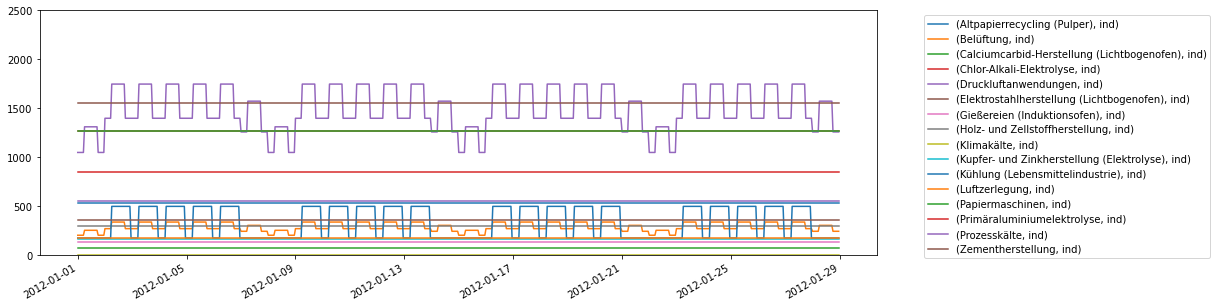

In [51]:
fig, ax = plt.subplots(figsize=(15, 5))
timeseries_dict[("ind", "SQ", "50%")].iloc[:672].plot(ax=ax)
plt.ylim([0,2500])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

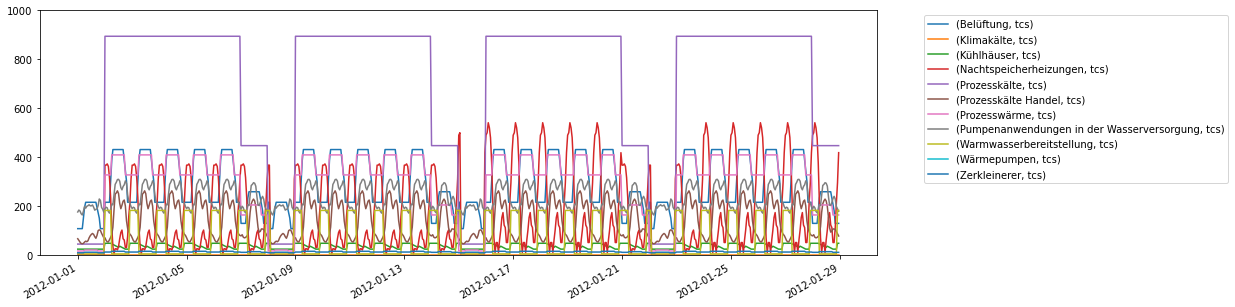

In [52]:
fig, ax = plt.subplots(figsize=(15, 5))
timeseries_dict[("tcs", "SQ", "50%")].iloc[:672].plot(ax=ax)
plt.ylim([0,1000])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

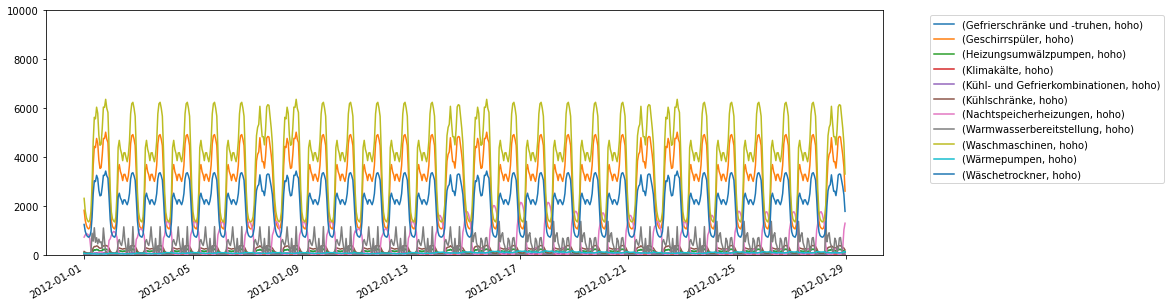

In [53]:
fig, ax = plt.subplots(figsize=(15, 5))
timeseries_dict[("hoho", "SQ", "50%")].iloc[:672].plot(ax=ax)
plt.ylim([0,10000])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

## Create availability time series per cluster
* Calculate weighted averages within clusters:
    * Iterate over all years and clusters
    * Determine simultaneous maximum positive and negative potentials taking into account eligibility for shifting, shedding or both
    * Assign simultaneous values as summed potentials
    * Rescale to a value of 1
* Calculate summed load profiles as well
* Put all results into dict structures
* Save the results, i.e. availability time series per cluster, to a csv file.

**Interpretation of availability factors per cluster**:
* Maximum availability per cluster does not necessarily have to be 1.
* A value of 0.88 implies that at maximum 88% of the overall cluster capacity are available at the same time. &rarr; Similar interpretation than simultaneity factor.
* Nevertheless, a rescaling is done here for the sake of easier interpretation. &rarr; I.e. maximum values will be 1.0 and cluster capacity is adapted (scaled_down) accordingly.

In [54]:
sector_dict = {}

for year in years:
    
    # Sector dict contains: original availabilites (pos & neg) and parameter datas
    sector_dict[year] = {
        "ind": (
            availability_ind_pos, 
            availability_ind_neg, 
            parameters_for_clustering_unjoined.loc[
                (parameters_for_clustering_unjoined["year"] == year)
                & (parameters_for_clustering_unjoined.index.get_level_values(1) == "ind")
            ]
        ),
        "tcs": (
            availability_tcs_pos, 
            availability_tcs_neg, 
            parameters_for_clustering_unjoined.loc[
                (parameters_for_clustering_unjoined["year"] == year)
                & (parameters_for_clustering_unjoined.index.get_level_values(1) == "tcs")
            ]
        ),
        "hoho": (
            availability_hoho_pos, 
            availability_hoho_neg, 
            parameters_for_clustering_unjoined.loc[
                (parameters_for_clustering_unjoined["year"] == year)
                & (parameters_for_clustering_unjoined.index.get_level_values(1) == "hoho")
            ]
        )
    }

In [55]:
# Extract info on combined clusters for tcs and hoho separately in order not to overwrite it
tcs_hoho_clusters = parameters_for_clustering.loc[
    (parameters_for_clustering["year"] == "SQ")
    & (parameters_for_clustering.index.get_level_values(1) == "tcs+hoho"),
    "cluster"
].unique()

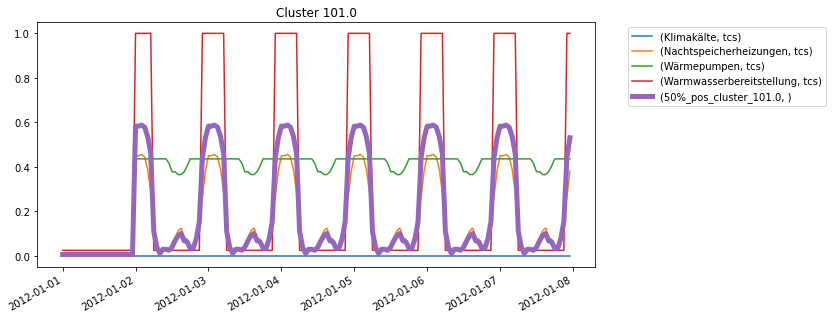

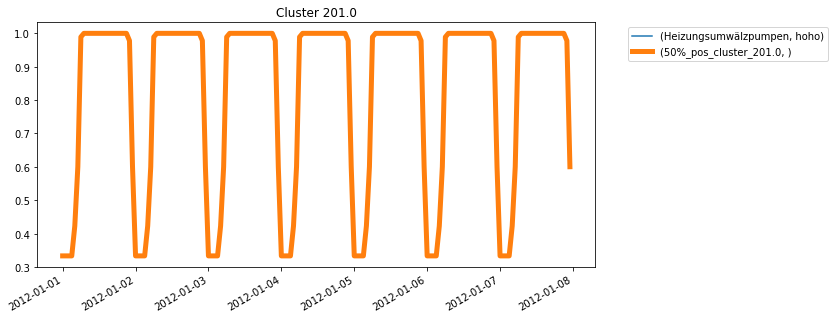

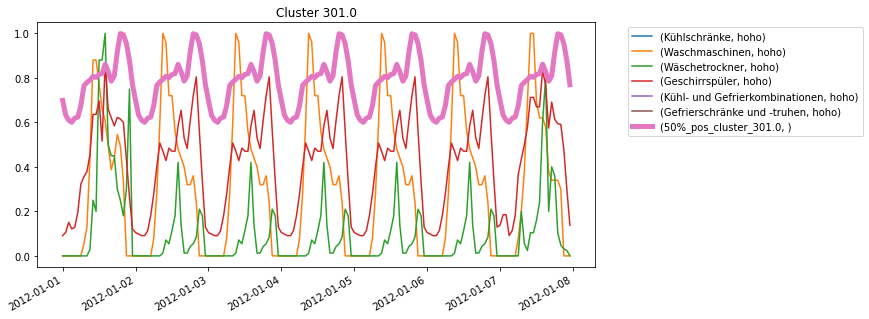

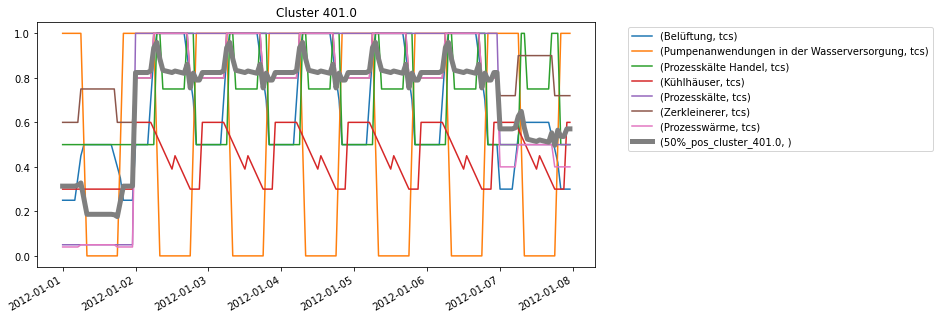

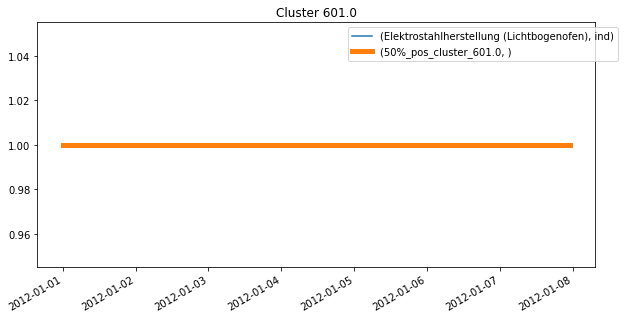

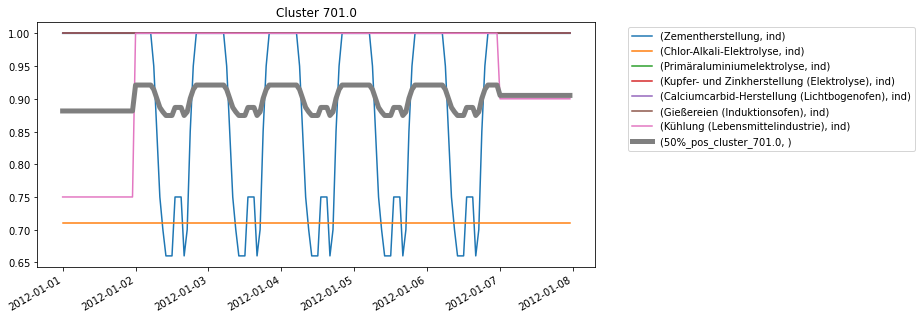

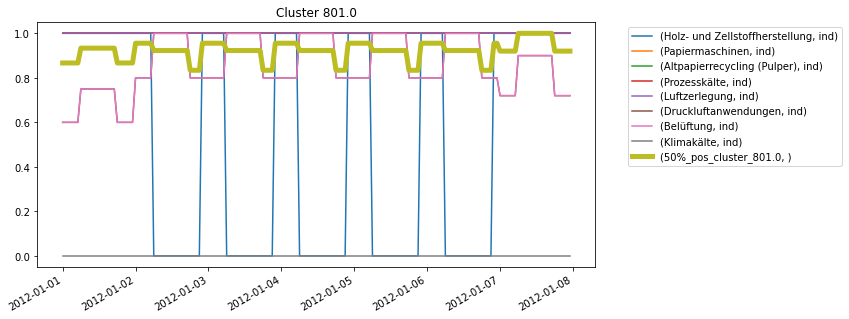

,5%_tcs+hoho_cluster-101_pos,5%_tcs+hoho_cluster-101_neg,50%_tcs+hoho_cluster-101_pos,50%_tcs+hoho_cluster-101_neg,95%_tcs+hoho_cluster-101_pos,95%_tcs+hoho_cluster-101_neg,5%_hoho_cluster-201_pos,5%_hoho_cluster-201_neg,50%_hoho_cluster-201_pos,50%_hoho_cluster-201_neg,...,50%_ind_cluster-701_pos,50%_ind_cluster-701_neg,95%_ind_cluster-701_pos,95%_ind_cluster-701_neg,5%_ind_cluster-801_pos,5%_ind_cluster-801_neg,50%_ind_cluster-801_pos,50%_ind_cluster-801_neg,95%_ind_cluster-801_pos,95%_ind_cluster-801_neg
2012-12-31 19:00:00,0.0344,0.5257,0.0345,0.4826,0.0180,0.5662,1.0000,0.4,1.0000,0.4,...,0.9932,0.4111,0.9888,0.3894,0.7766,1.0000,0.8340,0.7079,0.8879,0.7490
2012-12-31 20:00:00,0.0766,0.4788,0.0771,0.4314,0.0415,0.5233,1.0000,0.4,1.0000,0.4,...,1.0000,0.3805,1.0000,0.3564,0.7766,1.0000,0.8340,0.7079,0.8879,0.7490
2012-12-31 21:00:00,0.1517,0.3954,0.1530,0.3404,0.0832,0.4470,1.0000,0.4,1.0000,0.4,...,1.0000,0.3805,1.0000,0.3564,0.7766,1.0000,0.8340,0.7079,0.8879,0.7490
2012-12-31 22:00:00,0.4462,0.1616,0.4407,0.1763,0.2028,0.1478,0.9781,0.4,0.9781,0.4,...,1.0000,0.3805,1.0000,0.3564,0.9961,0.8901,0.9556,0.6682,0.9389,0.6892
2012-12-31 23:00:00,0.5353,0.1616,0.5308,0.1763,0.2524,0.1478,0.6002,0.4,0.6002,0.4,...,1.0000,0.3805,1.0000,0.3564,0.9961,0.8901,0.9556,0.6682,0.9389,0.6892


In [56]:
pot_cols = ["potential_pos_overall", "potential_neg_overall", "installed_cap"]
cols_of_interest = [i+"_"+j for i in quantile_cols for j in pot_cols]

# Use dicts and DataFrames to store overall cluster potential and availability time series per cluster
cluster_overall_pot_dict = {}
cluster_overall_ts_dict = {}
availability_clusters = pd.DataFrame(index=availability_ind_pos.index).drop("cluster")

# Create availability time series within clusters by calculating weighted averages
for year in years:
    
    cluster_overall_pot_df = pd.DataFrame(columns=cols_of_interest)
    load_timeseries = pd.DataFrame(index=timeseries_dict[("ind", "SQ","50%")].iloc[:-1].index)
    
    for cluster_number in np.sort(parameters_for_clustering["cluster"].unique()):
        
        to_concat = []
        cluster_data = {}
        
        for col in quantile_cols:
            sector = parameters_for_clustering_unjoined.loc[
                (parameters_for_clustering_unjoined["year"] == year)
                & (parameters_for_clustering_unjoined["cluster"] == cluster_number)
            ].index.get_level_values(1)[0]
            
            # introduce shortcuts for readability
            # original availability series and extract from parameter data set
            org_ava_pos = sector_dict[year][sector][0]
            org_ava_neg = sector_dict[year][sector][1]
            potentials = sector_dict[year][sector][2]
            
            # Calculate a weighted average for positive potentials 
            # (weights: maximum overall potential information)
            ava_pos = org_ava_pos.loc[
                :, org_ava_pos.loc["cluster"] == cluster_number
            ].drop("cluster")
            
            pot_pos = potentials.loc[
                potentials["cluster"] == cluster_number
            ]
            kind = parameters_for_clustering_unjoined.loc[
                (parameters_for_clustering_unjoined["year"] == year)
                & (parameters_for_clustering_unjoined["cluster"] == cluster_number)
            ]["kind"].unique()[0]
            
            # Choose positive potential columns dependent on eligibility:
            # shifting only: regular positive potential
            # shedding only: positive shedding potential
            # shifting and shedding: element-wise maximum of both (since they are competing)
            pot_pos_cols = ["_potential_pos_overall"]
            if kind == "shed_only":
                pot_pos_cols = ["_potential_pos_overall_shed"]
            if kind == "shift_shed":
                pot_pos_cols.append("_potential_pos_overall_shed")
            
            pot_pos = pot_pos[[
                col + pot_pos_col 
                for pot_pos_col in pot_pos_cols
            ]].max(axis=1)
            
            cluster_overall_pot_pos = pot_pos.sum()
            
            if cluster_overall_pot_pos != 0:
                ava_pos[col+"_pos_cluster_"+str(cluster_number)] = ava_pos.mul(
                    pot_pos
                ).div(cluster_overall_pot_pos).sum(axis=1)

                # Do rescaling: Adjust (reduce) potential information if necessary 
                max_pot_pos = (
                    ava_pos[col+"_pos_cluster_"+str(cluster_number)].max() 
                    * cluster_overall_pot_pos
                )
                # Scale max value of availability time series to 1   
                ava_pos[col+"_pos_cluster_"+str(cluster_number)] = (
                    ava_pos[col+"_pos_cluster_"+str(cluster_number)].div(
                        ava_pos[col+"_pos_cluster_"+str(cluster_number)].max()
                    )
                )

            # Calculate a weighted average for negative potentials 
            # (weights: maximum overall potential information)
            ava_neg = org_ava_neg.loc[
                :, org_ava_neg.loc["cluster"] == cluster_number
            ].drop("cluster")
            
            # Choose negative potential dependent on eligibility:
            # shedding only: No negative potential existing
            if kind == "shed_only":
                pot_neg = 0
                cluster_overall_pot_neg = 0
            else:
                pot_neg = potentials.loc[
                    potentials["cluster"] == cluster_number, 
                    col+"_potential_neg_overall"
                ]
                cluster_overall_pot_neg = pot_neg.sum()
            
            if cluster_overall_pot_neg != 0:
                ava_neg[col+"_neg_cluster_"+str(cluster_number)] = ava_neg.mul(
                    pot_neg
                ).div(cluster_overall_pot_neg).sum(axis=1)

                # Do rescaling: Adjust (reduce) potential information if necessary 
                max_pot_neg = (
                    ava_neg[col+"_neg_cluster_"+str(cluster_number)].max() 
                    * cluster_overall_pot_neg
                )
                # Scale max value of availability time series to 1   
                ava_neg[col+"_neg_cluster_"+str(cluster_number)] = (
                    ava_neg[col+"_neg_cluster_"+str(cluster_number)].div(
                        ava_neg[col+"_neg_cluster_"+str(cluster_number)].max()
                    )
                )
            else:
                ava_neg[col+"_neg_cluster_"+str(cluster_number)] = 0
                max_pot_neg = 0
            
            # Use proper cluster number label (int instead of float)
            if cluster_number not in tcs_hoho_clusters:
                cluster_label = sector+"_cluster-"+str(int(cluster_number))
            else:
                cluster_label = "tcs+hoho_cluster-"+str(int(cluster_number))

            # show exemplarily availability time series for clusters
            if year == "SQ":
                availability_clusters[col+"_"+cluster_label+"_pos"] = (
                    ava_pos[col+"_pos_cluster_"+str(cluster_number)]
                )
                availability_clusters[col+"_"+cluster_label+"_neg"] = (
                    ava_neg[col+"_neg_cluster_"+str(cluster_number)]
                )
                availability_clusters = availability_clusters.round(4)
            
                if col == "50%":
                    # Show a sample week for the clusters 
                    # ... for status quo, positive potentials and median values only
                    fig, ax = plt.subplots(figsize=(10,5))
                    _ = ava_pos.iloc[:168,:-1].plot(ax=ax)
                    _ = ava_pos.iloc[:168,-1:].plot(ax=ax, linewidth=5)
                    _ = plt.title("Cluster "+str(cluster_number))
                    _ = plt.legend(bbox_to_anchor=(1.05, 1))
                    plt.show()
                    fig.savefig(path_folder_plots+"cluster_"+str(cluster_number)+".png")
                    plt.close()
            
            # Save potential outputs
            cluster_data[col+"_potential_pos_overall"] = max_pot_pos
            cluster_data[col+"_potential_neg_overall"] = max_pot_neg
            
            # Assign load profiles and store them in a dict
            load_timeseries[col+"_"+cluster_label] = (
                timeseries_dict[("all_sectors", year, col)].loc[
                    :, timeseries_dict[("all_sectors", year, col)].loc["cluster"] 
                    == cluster_number
                ].sum(axis=1).drop("cluster")
            )
            
            max_cap = load_timeseries[col+"_"+cluster_label].max()
            
            # Save installed cluster capacity
            cluster_data[col+"_installed_cap"] = max_cap
            
        # Combine potential outputs and store them in dict of DataFrames
        cluster_overall_pot_df.loc[
            cluster_label, [
                i+"_"+j for i in quantile_cols 
                for j in pot_cols
            ]] = cluster_data

        cluster_overall_pot_df.loc[
            cluster_label, "kind"
        ] = kind
        
        cluster_overall_pot_dict[year] = cluster_overall_pot_df
        cluster_overall_ts_dict[year] = load_timeseries

display(availability_clusters.tail())

Introduce some fixes:
* Normalize load profiles again in order to be able to use them combined with maximum capacity demand
* Rename `installed_cap` to `max_cap` in order to prevent misinterpretation
* Limit positive potential to the value of the respective maximum simultaneously dispatched capacity, i.e. `max_cap`

In [57]:
# Normalize load profiles (for usage with pommes / oemof-solph)
# Rename column to max cap in order to be able to distinct it from installed capacity
for year in years:
    cluster_overall_ts_dict[year] = cluster_overall_ts_dict[year].div(
        cluster_overall_ts_dict[year].max()
    )
    for col in quantile_cols:
        cluster_overall_pot_dict[year].rename(
            {col + "_installed_cap": col + "_max_cap" for col in quantile_cols},
            axis=1,
            inplace=True
        )
    
    for col in quantile_cols:
        cluster_overall_pot_dict[year][col+"_potential_pos_overall"] = (
            cluster_overall_pot_dict[year][
                [col+"_potential_pos_overall", col+"_max_cap"]
            ].min(axis=1)
        )

In [58]:
cluster_overall_pot_dict["SQ"]

,5%_potential_pos_overall,5%_potential_neg_overall,5%_max_cap,50%_potential_pos_overall,50%_potential_neg_overall,50%_max_cap,95%_potential_pos_overall,95%_potential_neg_overall,95%_max_cap,kind
tcs+hoho_cluster-101,556.9500,2790,2794.58,1531.000000,7282.5,3739.84,4885.381250,14304.9,5144.46,shift_only
hoho_cluster-201,207.2500,1468,207.25,250.000000,2283,250,292.750000,2316,292.75,shift_shed
hoho_cluster-301,1456.6000,500,16011.4,3088.566400,1832.52,16168,6702.700000,9109.65,29765.9,shift_only
tcs_cluster-401,665.4495,1223.95,1766.49,2029.385821,2945.44,2358.31,2975.725531,12459.6,2975.73,shift_only
ind_cluster-601,498.0000,0,758.403,911.500000,0,1557,1143.600000,0,1908,shed_only
ind_cluster-701,1223.7000,356.697,2532.33,2287.500000,835.677,3332.7,4109.800000,1620.85,4592.16,shift_shed
ind_cluster-801,890.0370,314.285,4012.61,2079.238000,1627.36,5848.38,6116.776000,4709.28,10392.7,shift_only


In [59]:
cluster_overall_pot_dict["2050"]

,5%_potential_pos_overall,5%_potential_neg_overall,5%_max_cap,50%_potential_pos_overall,50%_potential_neg_overall,50%_max_cap,95%_potential_pos_overall,95%_potential_neg_overall,95%_max_cap,kind
tcs+hoho_cluster-101,284.168375,1342.77,27319.4,1824.683746,9242.74,28477.4,9882.157144,20602.7,29635.3,shift_only
hoho_cluster-201,41.128758,0,41.1288,49.612305,0,49.6123,58.095851,0,58.0959,shift_shed
hoho_cluster-301,924.209556,500,4625.03,1586.946325,1148.67,4653.34,2185.120652,3107.27,4681.66,shift_only
tcs_cluster-401,967.321012,1298.06,3600.42,2593.840538,3144.87,4509.57,5425.769627,16922.2,5425.77,shift_only
ind_cluster-601,203.562636,0,1074.23,602.422892,0,1074.23,994.701536,0,1074.23,shed_only
ind_cluster-701,721.455793,331.528,1844.91,1305.749541,571.066,2086.46,2040.243806,742.924,2328.02,shift_shed
ind_cluster-801,451.219793,372.259,6799.23,1723.366262,1791.21,8503.04,3301.165614,3793.28,10206.9,shift_only


In [60]:
cluster_overall_ts_dict["2050"].max()

5%_tcs+hoho_cluster-101     1.0
50%_tcs+hoho_cluster-101    1.0
95%_tcs+hoho_cluster-101    1.0
5%_hoho_cluster-201         1.0
50%_hoho_cluster-201        1.0
95%_hoho_cluster-201        1.0
5%_hoho_cluster-301         1.0
50%_hoho_cluster-301        1.0
95%_hoho_cluster-301        1.0
5%_tcs_cluster-401          1.0
50%_tcs_cluster-401         1.0
95%_tcs_cluster-401         1.0
5%_ind_cluster-601          1.0
50%_ind_cluster-601         1.0
95%_ind_cluster-601         1.0
5%_ind_cluster-701          1.0
50%_ind_cluster-701         1.0
95%_ind_cluster-701         1.0
5%_ind_cluster-801          1.0
50%_ind_cluster-801         1.0
95%_ind_cluster-801         1.0
dtype: float64

In [61]:
cluster_labels = cluster_overall_pot_dict["SQ"].index.values
cluster_ts_by_cols = {}
ava_pos_ts_by_cols = {}
ava_neg_ts_by_cols = {}

# Split timeseries into subsets
for col in quantile_cols:
    for year in years:
        ava_cols = [i+"_"+j for i in [col] for j in cluster_labels]
        ava_cols_pos = [i+"_"+j+"_pos" for i in [col] for j in cluster_labels]
        ava_cols_neg = [i+"_"+j+"_neg" for i in [col] for j in cluster_labels]

        cluster_ts_by_cols[col+"_"+year] = cluster_overall_ts_dict[year][ava_cols]
        ava_pos_ts_by_cols[col+"_"+year] = availability_clusters[ava_cols_pos]
        ava_neg_ts_by_cols[col+"_"+year] = availability_clusters[ava_cols_neg]

In [62]:
if write_outputs:
    availability_clusters.to_csv(
        path_folder_availability+filename_availability_out, 
        sep=";", 
        decimal=","
    )
    write_multiple_sheets(
        cluster_ts_by_cols, 
        path_folder_parameterization, 
        filename_load_profiles_out+".xlsx"
    )

## Group the data within the clusters and write outputs
* Determine, how the grouping will take place and which aggregation rules to apply for a parameter by specifying them in a dictionary
* Perform the actual aggregation
* Rename the clusters to a more human readable form and do some slight renamings

In [63]:
# Extract parameters of interest for further model-based analyses
params_of_interest = params_to_use + params_remaining
params_of_interest = [param[1] for param in params_of_interest]

In [64]:
# Extract aggregation rules
grouping_cols = ["cluster"]
agg_rules = {}

for param, agg_rule in parameters_agg_dict.items():
    if param not in params_of_interest:
        continue
    else:
        for col in quantile_cols:
            agg_rules[(col, param)] = agg_rule

In [65]:
for col in quantile_cols:
    agg_rules[col] = {
        key[0] + "_" + key[1]: value for key, value in agg_rules.items()
        if col == key[0]
    }

In [66]:
# Rename clusters to more intuitive names
name_dict = {
    "tcs+hoho_cluster-101": "tcs+hoho_cluster_shift_only",
    "hoho_cluster-201": "hoho_cluster_shift_shed",
    "hoho_cluster-301": "hoho_cluster_shift_only",
    "tcs_cluster-401": "tcs_cluster_shift_only",
    "ind_cluster-601": "ind_cluster_shed_only",
    "ind_cluster-701": "ind_cluster_shift_shed",
    "ind_cluster-801": "ind_cluster_shift_only"
}

In [67]:
# Calculate the parameters for the clusters
overall_dict = {}
pot_cols = [
    "potential_pos_overall",
    "potential_neg_overall",
    "max_cap"
]
dur_cols = [
    "interference_duration_neg",
    "interference_duration_pos", 
    "interference_duration_pos_shed", 
    "regeneration_duration", 
    "shifting_duration"
]
cost_cols = [
    "fixed_costs",
    "variable_costs",
    "specific_investments"
]
other_cols = [
    "maximum_activations_year",
    "installed_cap", "max_cap",
    "potential_neg_overall",
    "potential_pos_overall"
]

parameters_for_clustering = parameters_for_clustering.set_index("kind", append=True)

for year in years:

    params_year = parameters_for_clustering.loc[
        parameters_for_clustering["year"] == year
    ].drop(columns="year").astype("float64").reset_index(level=[1, 2])
        
    for col in quantile_cols:
        
        overall_dict[col+"_"+year] = group_potential(
            params_year, 
            grouping_cols=["cluster", "sector", "kind"],
            agg_rules=agg_rules[col],
            # potential pos overall is used due to it giving the best data basis
            weight_col=col+"_potential_pos_overall"
        ).round(2)
        
        cols_potentials = [i+"_"+j for i in [col] for j in pot_cols]

        # Update potential data with availability information from above
        if adjust_potentials:
            overall_dict[col+"_"+year][cols_potentials] = (
                cluster_overall_pot_dict[year][cols_potentials].astype(float).round(2)
            )

        # Add country and bus information (needed in pommes)
        overall_dict[col+"_"+year][col+"_country"] = "DE"
        overall_dict[col+"_"+year][col+"_from"] = "DE_bus_el"
        
        
        # Rounding: costs to 1 digit; durations to nearest integer; other params to 0 digits
        cols_duration = [i+"_"+j for i in [col] for j in dur_cols]
        cols_costs = [i+"_"+j for i in [col] for j in cost_cols]
        cols_other = [i+"_"+j for i in [col] for j in other_cols]
        
        # Round durations and replace zero values
        overall_dict[col+"_"+year][cols_duration] = overall_dict[col+"_"+year][cols_duration].round(0)
        overall_dict[col+"_"+year][cols_duration] = overall_dict[col+"_"+year][cols_duration].replace({0:1})
        overall_dict[col+"_"+year][cols_costs] = overall_dict[col+"_"+year][cols_costs].round(1)
        # Replace zero cost values which might occur in rounding
        overall_dict[col+"_"+year][cols_costs] = overall_dict[col+"_"+year][cols_costs].replace({0.0:0.01})
        overall_dict[col+"_"+year][cols_other] = overall_dict[col+"_"+year][cols_other].round(0)

        # Do some renaming
        overall_dict[col+"_"+year].rename(name_dict, inplace=True)
        overall_dict[col+"_"+year].drop(columns="sector", inplace=True)
        overall_dict[col+"_"+year].columns = overall_dict[col+"_"+year].columns.str.split(
            "_", 1, expand=True
        ).get_level_values(1)
        overall_dict[col+"_"+year].rename(columns={np.nan: "kind"})

In [68]:
# Info on remaining categories is optionally stored to match it with availability time series
# resp. to assign similar availability time series when data is missing.
parameters_for_clustering = parameters_for_clustering.reset_index(level=2)

if write_categories:
    parameters_for_clustering[
        parameters_for_clustering["year"] == "SQ"
    ].to_csv(path_folder_in+"remaining_categories.csv", sep=";")

In [69]:
# Write the parameter outputs to Excel
if write_outputs: 
    write_multiple_sheets(overall_dict, path_folder_parameterization, filename_out+"_overall.xlsx") 

## Write outputs
Write outputs needed for the power market model runs separately to csv files

Do some adjustments:
* Simple column naming adjustment
* Timeseries adjustments / harmonization:
> __*NOTE*__: _2017 is used as a simulation year for the power market model._
> * _Availability time series were (mostly) derived for 2012._
> * _Since 2017 and 2012 both started with a Sunday, no shifts of weekdays is necessary._
> * _Only the last day of 2012 is cut here since 2012 was a leap year._
> * _At the end, this only is a very rough estimate / first guess which **should be improved**._

In [70]:
# Do some column naming adjustment
cases = [col + "_SQ" for col in quantile_cols]

for case in cases:
    cluster_ts_by_cols[case].columns = cluster_ts_by_cols[case].columns.str.split(
        "_", 1, expand=True
    ).get_level_values(1)
    ava_pos_ts_by_cols[case].columns = ava_pos_ts_by_cols[case].columns.str.split(
        "_", 1, expand=True
    ).get_level_values(1).str[:-4]
    ava_neg_ts_by_cols[case].columns = ava_neg_ts_by_cols[case].columns.str.split(
        "_", 1, expand=True
    ).get_level_values(1).str[:-4]

    cluster_ts_by_cols[case].rename(name_dict, axis=1, inplace=True)
    ava_pos_ts_by_cols[case].rename(name_dict, axis=1, inplace=True)
    ava_neg_ts_by_cols[case].rename(name_dict, axis=1, inplace=True)

In [71]:
# Replace time series index with 2017 one
new_timeindex = pd.date_range(start="2017-01-01 00:00", periods=8784, freq="H")

for case in cases:
    cluster_ts_by_cols[case]["new_timeindex"] = new_timeindex
    ava_pos_ts_by_cols[case]["new_timeindex"] = new_timeindex
    ava_neg_ts_by_cols[case]["new_timeindex"] = new_timeindex
    
    cluster_ts_by_cols[case] = cluster_ts_by_cols[case].set_index(
        "new_timeindex", drop=True
    ).iloc[:8760].round(4)
    ava_pos_ts_by_cols[case] = ava_pos_ts_by_cols[case].set_index(
        "new_timeindex", drop=True
    ).iloc[:8760].round(4)
    ava_neg_ts_by_cols[case] = ava_neg_ts_by_cols[case].set_index(
        "new_timeindex", drop=True
    ).iloc[:8760].round(4)

In [72]:
cluster_ts_by_cols["5%_SQ"].head()

,tcs+hoho_cluster_shift_only,hoho_cluster_shift_shed,hoho_cluster_shift_only,tcs_cluster_shift_only,ind_cluster_shed_only,ind_cluster_shift_shed,ind_cluster_shift_only
new_timeindex,,,,,,,
2017-01-01 00:00:00,0.1909,0.3496,0.3496,0.1573,1.0,0.8725,0.6257
2017-01-01 01:00:00,0.2121,0.2710,0.2710,0.1550,1.0,0.8725,0.6257
2017-01-01 02:00:00,0.2236,0.2317,0.2317,0.1501,1.0,0.8725,0.6257
2017-01-01 03:00:00,0.2188,0.2119,0.2119,0.1450,1.0,0.8725,0.6257
2017-01-01 04:00:00,0.2101,0.2042,0.2042,0.1434,1.0,0.8725,0.6257


In [73]:
for case in cases:
    # Node information
    overall_dict[case].to_csv(
        path_folder_parameterization+"sinks_demand_response_el_"
        +case.split("_")[0][:-1]+".csv"
    )
    # Load profile information
    cluster_ts_by_cols[case].to_csv(
        path_folder_parameterization+"sinks_demand_response_el_ts_"
        +case.split("_")[0][:-1]+".csv"
    )
    # Availability information
    ava_pos_ts_by_cols[case].to_csv(
        path_folder_parameterization+"sinks_demand_response_el_ava_pos_ts_"
        +case.split("_")[0][:-1]+".csv"
    )
    ava_neg_ts_by_cols[case].to_csv(
        path_folder_parameterization+"sinks_demand_response_el_ava_neg_ts_"
        +case.split("_")[0][:-1]+".csv"
    )

# Bibliography
Benz, Fabian (2019): Ermittlung von Kosten und Zeitverfügbarkeit für flexible Stromnachfragen in der Industrie in Deutschland, Freie wissenschaftliche Arbeit zur Erlangung des Grades eines Bachelor of Science am Fachgebiet Energie- und Ressourcenmanagement der TU Berlin.

Gils, Hans Christian (2015): Balancing of Intermittent Renewable Power Generation by Demand Response and Thermal Energy Storage. Dissertation. Universität Stuttgart, Stuttgart.

Kochems, Johannes (2020): Lastflexibilisierungspotenziale in Deutschland - Bestandsaufnahme und Entwicklungsprojektionen. Langfassung. In: IEE TU Graz (Hg.): EnInnov 2020 - 16. Symposium Energieinnovation. Energy for Future - Wege zur Klimaneutralität. Graz, 12.-14.02, https://www.tugraz.at/fileadmin/user_upload/tugrazExternal/4778f047-2e50-4e9e-b72d-e5af373f95a4/files/lf/Session_E5/553_LF_Kochems.pdf, accessed 11.05.2020.

Odeh, Jonas (2019): Ermittlung von Kosten und Zeitverfügbarkeiten für die Flexibilisierung von Stromnachfragen im GHD-Sektor, Freie wissenschaftliche Arbeit zur Erlangung des Grades eines Bachelor of Science am Fachgebiet Energie- und Ressourcenmanagement der TU Berlin.

Stange, Rico (2019): Ermittlung von Kosten und Zeitverfügbarkeiten einer Flexibilisierung der Stromnachfrage, Freie wissenschaftliche Arbeit zur Erlangung des Grades eines Bachelor of Science am Fachgebiet Energie- und Ressourcenmanagement der TU Berlin.